In [1]:
import pandas as pd 
import numpy as np
import os 
import re 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
import scipy.stats as sp_stats

import matplotlib
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 

csv_dir = "csv"

In [2]:
plasma_AC_df = pd.read_csv("{0}/plasma_AC.csv".format(csv_dir),header=3)
tissue_amine_df = pd.read_csv("{0}/tissue_amine.csv".format(csv_dir),header=3)
tissue_AC_df = pd.read_csv("{0}/tissue_AC.csv".format(csv_dir),header=3)

tissue_amine_df.dropna(how="all",inplace=True)
tissue_amine_df.dropna(how="all",axis=1,inplace=True)
plasma_AC_df.dropna(how="all",inplace=True)

tissue_amine_df.rename(columns=lambda x: x.strip(),inplace=True)
tissue_AC_df.rename(columns=lambda x: x.strip(),inplace=True)
plasma_AC_df.rename(columns=lambda x: x.strip(),inplace=True)


#AC and amine columns 
amine_columns = tissue_amine_df.columns[4:]
AC_columns = tissue_AC_df.columns[4:]
plasma_AC_columns = plasma_AC_df.columns[7:]

#Convert to nM for consistency with HWDC original experiment data 
tissue_AC_df.loc[:,AC_columns] = tissue_AC_df.loc[:,AC_columns]*1000
tissue_amine_df.loc[:,amine_columns] = tissue_amine_df.loc[:,amine_columns]
plasma_AC_df.loc[:,plasma_AC_columns] = plasma_AC_df.loc[:,plasma_AC_columns]*1000

show_tables = False
if show_tables:
    with pd.option_context('display.max_rows',None):
        display(plasma_AC_df)
        display(tissue_amine_df)
        display(tissue_AC_df)
        
nonOH_DC = AC_columns[~AC_columns.str.contains("OH|DC")]
FA_derived_ACs = nonOH_DC[~nonOH_DC.str.contains(":[4,5]")]
FA_derived_ACs = FA_derived_ACs.drop("C2")
SFA_ACs = FA_derived_ACs[~FA_derived_ACs.str.contains(":")].tolist()
UFA_ACs = FA_derived_ACs[FA_derived_ACs.str.contains(":")].tolist()    
soybean_ACs = ["C16","C18","C18:1","C18:2","C18:3"]    

In [229]:
import scipy as sp
# import learn as sklearn
from sklearn.cluster import KMeans

def sort_cluster_labels(labels,centers):
    if len(centers) == 2:
        unique_sorted_labels = list(set(labels))
        unique_sorted_labels.sort()
#         original_centers_mapping = dict(zip(unique_sorted_labels,centers))
        #Determine if clusters[0] has more features > clusters[1]; if so, reverse labels and return
        if sum(centers[0]>centers[1]) > len(centers[0])/2:  
            #Inversion of cluster order 
            invert_dict = {unique_sorted_labels[0]:unique_sorted_labels[1],
                          unique_sorted_labels[1]:unique_sorted_labels[0]}
            labels_srs = pd.Series(labels)
            inv_labels = labels_srs.map(invert_dict).values
            return inv_labels
        else: 
            return labels

    #TODO: generalizable case with 3+ clusters and multiple comparisons
    #     print(np.sum(centers,axis=1))

def kmeans_cluster_ms(ms_df,analytes,tissues,force_separate_arms=True,nan_handling="drop_samples",
                     offset=True):
    sample_ids = ms_df["SampleID"].unique().tolist()
    sample_arm = [re.match(r'MG\d+_([AB])[MF]\d+',sample_id).groups()[0] for sample_id in sample_ids]
    obs_df = pd.DataFrame(index=sample_ids)
    obs_df.loc[:,"Arm"] = sample_arm
    for tissue in tissues: 
        tissue_df = ms_df.loc[ms_df["Tissue"]==tissue]
        for analyte in analytes: 
            tissue_analyte_data = tissue_df[analyte]
            col_key = "{0}_{1}".format(tissue,analyte)
            obs_df.loc[tissue_df["SampleID"],col_key] = tissue_analyte_data.tolist()
    
    analyte_cols = obs_df.columns[1:].tolist()
    if nan_handling == "drop_samples" and obs_df.isna().values.any():
        obs_df = obs_df.dropna(axis=0,how="any")
    if force_separate_arms:
        #Cluster A observations
        obs_A_df = obs_df.loc[obs_df["Arm"]=="A"].drop("Arm",axis=1) #A data, numeric analyte data only
        whitened_A = sp.cluster.vq.whiten(obs_A_df)
        A_km_results = KMeans(n_clusters=2,random_state=0).fit(whitened_A)
        A_cluster_labels,A_cluster_centers = A_km_results.labels_, A_km_results.cluster_centers_
        A_cluster_labels = sort_cluster_labels(A_cluster_labels,A_cluster_centers)
        
        #Cluster B observations
        obs_B_df = obs_df.loc[obs_df["Arm"]=="B"].drop("Arm",axis=1) #B data, numeric analyte data only
        whitened_B = sp.cluster.vq.whiten(obs_B_df)
        B_km_results = KMeans(n_clusters=2,random_state=0).fit(whitened_B)
        B_cluster_labels, B_cluster_centers = B_km_results.labels_, B_km_results.cluster_centers_
        B_cluster_labels = sort_cluster_labels(B_cluster_labels,B_cluster_centers)
        #TODO: QC to make sure higher centroid has higher mean cluster label
        #Offset B cluster labels, add both to obs_df 
        if offset:
            B_cluster_labels = B_cluster_labels + len(set(A_cluster_labels))
        obs_df.loc[obs_A_df.index,"Cluster"] = A_cluster_labels
        obs_df.loc[obs_B_df.index,"Cluster"] = B_cluster_labels
    else:
        whitened_obs = sp.cluster.vq.whiten(obs_A_df.drop("Arm",axis=1))
        km_results = KMeans(n_clusters=2,random_state=0).fit(whitened_obs)
        cluster_labels = km_results.labels_
        obs_df.loc[:,"Cluster"] = cluster_labels
    reordered_cols = ["Arm","Cluster"]
    reordered_cols.extend(analyte_cols)
    obs_df = obs_df[reordered_cols]
    obs_df.loc[:,"Cluster"] = obs_df.loc[:,"Cluster"].astype(int)
    return obs_df

soybean_4ACs = ["C16","C18","C18:1","C18:2"]
soybean_5ACs = ["C16","C18","C18:1","C18:2","C18:3"]

soybean_obs_df = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_4ACs,tissues=["Gastroc","Quadriceps","Heart"])
soybean5_muscle_obs_df = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_5ACs,tissues=["Gastroc","Quadriceps","Heart"])
SFA_obs_df = kmeans_cluster_ms(tissue_AC_df,analytes=SFA_ACs,tissues=["Gastroc","Quadriceps","Heart"])
UFA_obs_df = kmeans_cluster_ms(tissue_AC_df,analytes=UFA_ACs,tissues=["Gastroc","Quadriceps","Heart"])
soybean_jej_obs_df = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_5ACs,tissues=["Jejunum"])
soybean4_jej_obs_df = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_4ACs,tissues=["Jejunum"])

soybean5_skmuscle_obs_df = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_5ACs,tissues=["Gastroc","Quadriceps"])
soybean_jej_obs_df = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_5ACs,tissues=["Jejunum"])
soybean_intestine_obs_df = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_5ACs,tissues=["Jejunum","Colon"])
# display(soybean_intestine_obs_df)

cluster_columns = ["Soybean4_allmuscle","Soybean5_allmuscle","Soybean5_skm","Soybean5_jej","Soybean4_jej","Soybean5_intestine"]
cluster_df = pd.DataFrame(index=soybean_obs_df.index,columns=cluster_columns)
cluster_df.loc[:,"Soybean4_allmuscle"] = soybean_obs_df["Cluster"]
cluster_df.loc[:,"Soybean5_allmuscle"] = soybean5_muscle_obs_df["Cluster"]
cluster_df.loc[:,"Soybean5_skm"] = soybean5_skmuscle_obs_df["Cluster"]
cluster_df.loc[:,"Soybean5_jej"] = soybean_jej_obs_df["Cluster"]
cluster_df.loc[:,"Soybean4_jej"] = soybean4_jej_obs_df["Cluster"]
cluster_df.loc[:,"Soybean5_intestine"] = soybean_intestine_obs_df["Cluster"]
display(cluster_df)


cluster_df.to_csv("analyte_cluster_labels.csv")

,Soybean4_allmuscle,Soybean5_allmuscle,Soybean5_skm,Soybean5_jej,Soybean4_jej,Soybean5_intestine
MG01_AM1,0,0,0,0,0,NaN
MG01_AM2,0,0,0,1,1,1.0
MG01_AM3,0,0,0,0,0,NaN
MG01_AM4,1,1,1,1,1,1.0
MG01_AM5,0,0,0,0,0,0.0
MG01_AM6,0,0,0,0,0,0.0
MG01_AM7,0,0,0,1,1,1.0
MG01_AM8,1,1,1,0,0,0.0
MG01_AF1,0,0,0,0,0,0.0
MG01_AF2,0,0,0,0,0,0.0


In [4]:

#Correlation analysis for soybean derived ACs between different muscles 
# HWDC_cluster_palette={"0":"#FEACA7","1":"#FF2804","2":"#D4D4D4","3":"#000000"} #0,2 lighter
HWDC_cluster_palette={0:"#FEACA7",1:"#FF2804",2:"#AAAAAA",3:"#000000"} #1,2 lighter (for unfixed cluster labels)
HWDC_reds_cluster_palette = {0:"#FEACA7",1:"#FF2804"}
HWDC_blacks_cluster_palette = {2:"#AAAAAA",3:"#000000"}

def SCC_plot(ms_df,analytes,tissue1="Gastroc",tissue2="Quadriceps",correlation="Spearman",title_analytes_label="",ax=None):
        
    long_df = analyte_long_df(ms_df,analytes=analytes,tissue1=tissue1,tissue2=tissue2)
    if not ax: 
        fig,ax = plt.subplots(1,1,figsize=(6,6))
    scc_r, scc_p = sp.stats.spearmanr(a=long_df, axis=0, nan_policy='propagate', alternative='two-sided')
    pcc_r, pcc_p = sp.stats.pearsonr(x=long_df[tissue1],y=long_df[tissue2])
    sns.scatterplot(data=long_df,x=tissue1,y=tissue2,ax=ax)
    
    scc_str = "Spearman R: {:.3f}".format(scc_r,scc_p)
    pcc_str = "Pearson R: {:.3f}".format(pcc_r,pcc_p)
    xmin,xmax = ax.get_xlim()
    ymin,ymax = ax.get_ylim()
    xdiff, ydiff = xmax-xmin, ymax-ymin
    ax.text(x=xmin+xdiff*.02,y=ymax-ydiff*.05,s=scc_str,fontsize=10)
    ax.text(x=xmin+xdiff*.02,y=ymax-ydiff*.1,s=pcc_str,fontsize=10)
    title_str = "{0} vs {1} for {2}".format(tissue1,tissue2,title_analytes_label)
    ax.set_title(title_str,fontsize=14)
    
def SCC_plot_cluster_hue(ms_df,analytes,obs_df,tissue1="Gastroc",tissue2="Quadriceps",title_analytes_label="",
                         ax=None,hue_type="cluster",axes_analyte_map=None):
    """
    """
    long_df = analyte_long_df(ms_df,analytes=analytes,tissue1=tissue1,tissue2=tissue2,
                              obs_df=obs_df,axes_analyte_map=axes_analyte_map)
    
    scc_r, scc_p = sp.stats.spearmanr(a=long_df[[tissue1,tissue2]], axis=0, nan_policy='propagate', alternative='two-sided')
    pcc_r, pcc_p = sp.stats.pearsonr(x=long_df[tissue1],y=long_df[tissue2])
    display(long_df)
    
    if hue_type == "cluster":
        if not ax: 
            fig,ax = plt.subplots(1,1,figsize=(6,6))
            fig.tight_layout(pad=3)
            axes = [ax]
        sns.scatterplot(data=long_df,x=tissue1,y=tissue2,ax=ax,hue="Cluster",palette=HWDC_cluster_palette,alpha=0.8)
        title_str = "{0} vs {1} for {2}, clustered by analyte level".format(tissue1,tissue2,title_analytes_label)
        ax.set_title(title_str,fontsize=14)
    elif hue_type == "analyte":
        if not ax: 
            fig,ax = plt.subplots(1,1,figsize=(6,6))
            fig.tight_layout(pad=3)
            axes = [ax]
        sns.scatterplot(data=long_df,x=tissue1,y=tissue2,ax=ax,hue="Analyte_Arm",
                        palette=sns.color_palette("Paired")[:len(analytes)*2],alpha=0.8)
        title_str = "{0} vs {1} for {2}, colored by analyte level".format(tissue1,tissue2,title_analytes_label)
        ax.set_title(title_str,fontsize=14)
        
    elif hue_type == "both":
        fig,axes = plt.subplots(1,2,figsize=(14,7))
        
        ax1, ax2 = axes 
        new_labels = ["A Cluster 1","A Cluster 2","B cluster 1","B cluster 2"] #Needs reordering
        if not axes_analyte_map:
            fig.tight_layout(pad=3)
            sns.scatterplot(data=long_df,x=tissue1,y=tissue2,ax=ax1,hue="Cluster",palette=HWDC_cluster_palette,alpha=0.8)
            sns.scatterplot(data=long_df,x=tissue1,y=tissue2,ax=ax2,hue="Analyte_Arm",
                            palette=sns.color_palette("Paired")[:len(analytes)*2][::-1],alpha=0.8)
            handles, labels = [],[]
            collect_legends=False
            if collect_legends:
                for ax in axes: 
                    handles_, labels_ = ax.get_legend_handles_labels()
                    if ax == ax1:
                        labels_ = new_labels
                    handles.extend(handles_)
                    labels.extend(labels_)
                    ax.get_legend().remove()
                ax.legend(handles, labels, loc='upper left')
                sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) 
            else: #Stagger legends - can adjust positioning in bbox_to_anchor flags; 
                handles, labels_ = ax1.get_legend_handles_labels()
                ax1.legend(handles,new_labels,title="Cluster")
                sns.move_legend(ax1, "upper left", bbox_to_anchor=(2.15, 1)) #left axes legend
                sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 0.72)) #right axes legend
        else: 
            fig.tight_layout(pad=8)
            analyte_palette = sns.color_palette("Paired")[:len(analytes)][::-1]
            palette_index = 0
            for i,ax_cluster in enumerate(set(axes_analyte_map.values())):
                ax_data = long_df.loc[long_df["Analyte_Axes"] == ax_cluster,:]
                n_analytes = len(ax_data["Analyte"].unique())
                analytes_str = ", ".join(ax_data["Analyte"].unique())
                if i == 0: 
                    sns.scatterplot(data=ax_data,x=tissue1,y=tissue2,ax=ax1,hue="Cluster",palette=HWDC_cluster_palette,alpha=0.8)
                    sns.scatterplot(data=ax_data,x=tissue1,y=tissue2,ax=ax2,hue="Analyte",
                            palette=analyte_palette[:n_analytes],alpha=0.8)
                    for ax in axes:
                        ax.set_xlabel("{0} ({1})".format(tissue1,analytes_str),fontsize=12)
                        ax.set_ylabel("{0} ({1})".format(tissue2,analytes_str),fontsize=12)
                else:
                    ax1_twinx, ax2_twinx = ax1.twinx(), ax2.twinx()
                    ax1_twin, ax2_twin = ax1_twinx.twiny(),ax2_twinx.twiny()
                    sns.scatterplot(data=ax_data,x=tissue1,y=tissue2,ax=ax1_twin,hue="Cluster",palette=HWDC_cluster_palette,alpha=0.8)
                    sns.scatterplot(data=ax_data,x=tissue1,y=tissue2,ax=ax2_twin,hue="Analyte",
                            palette=analyte_palette[palette_index:palette_index+n_analytes],alpha=0.8)
                    for ax in [ax1_twin,ax2_twin]:
                        ax.set_xlabel("{0} ({1})".format(tissue1,analytes_str),fontsize=12)
                    for ax in [ax1_twinx,ax2_twinx]:
                        ax.set_ylabel("{0} ({1})".format(tissue2,analytes_str),fontsize=12)
                    ax1_twin.get_legend().remove()
                palette_index += n_analytes
            handles, labels_ = ax1.get_legend_handles_labels()    
            ax1.legend(handles,new_labels,title="Cluster")
            sns.move_legend(ax1, "upper left", bbox_to_anchor=(2.5, 1))
            
            ax2_handles, ax2_labels = [], [] 
            for ax in [ax2,ax2_twin]:
                handles_, labels_ = ax.get_legend_handles_labels()
                ax2_handles.extend(handles_)
                ax2_labels.extend(labels_)
                ax.get_legend().remove()
            ax2.legend(ax2_handles,ax2_labels,title="Analyte")
            sns.move_legend(ax2, "upper left", bbox_to_anchor=(1.18, 0.72))
            
        title_str = "{0} vs {1}\n{2}\nClustered by Analyte Level within Arm".format(tissue1,tissue2,title_analytes_label)
        ax1.set_title(title_str,fontsize=14)
        title_str = "{0} vs {1}\n{2}\nColored by Analyte and Arm".format(tissue1,tissue2,title_analytes_label)
        ax2.set_title(title_str,fontsize=14)
        
        
    scc_str = "Spearman R: {:.3f}".format(scc_r,scc_p)
    pcc_str = "Pearson R: {:.3f}".format(pcc_r,pcc_p)
    for ax in axes:
        xmin,xmax = ax.get_xlim()
        ymin,ymax = ax.get_ylim()
        xdiff, ydiff = xmax-xmin, ymax-ymin
        ax.text(x=xmin+xdiff*.02,y=ymax-ydiff*.05,s=scc_str,fontsize=10)
        ax.text(x=xmin+xdiff*.02,y=ymax-ydiff*.1,s=pcc_str,fontsize=10)
    return fig 

    
    
        

,Gastroc,Quadriceps,Analyte,Arm,MouseID,Analyte_Axes,Cluster,Analyte_Arm
MG01_AM1_C16,207.675,207.04,C16,A,MG01_AM1,0,0,C16_A
MG01_AM2_C16,166.394,233.291,C16,A,MG01_AM2,0,0,C16_A
MG01_AM3_C16,174.651,225.246,C16,A,MG01_AM3,0,0,C16_A
MG01_AM4_C16,371.529,605.243,C16,A,MG01_AM4,0,1,C16_A
MG01_AM5_C16,143.743,211.486,C16,A,MG01_AM5,0,0,C16_A
...,...,...,...,...,...,...,...,...
MG01_BF6_C18:2,370.742,527.562,C18:2,B,MG01_BF6,1,3,C18:2_B
MG01_BF7_C18:2,488.195,790.585,C18:2,B,MG01_BF7,1,3,C18:2_B
MG01_BF8_C18:2,462.671,538.593,C18:2,B,MG01_BF8,1,3,C18:2_B
MG01_BF9_C18:2,351.924,594.183,C18:2,B,MG01_BF9,1,2,C18:2_B


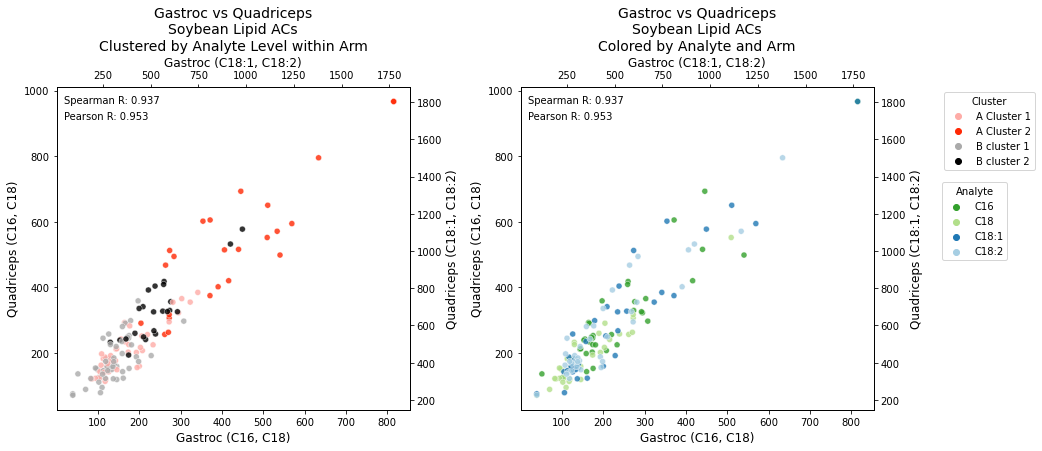

In [58]:
figures_dir = "figures/analyte_scatter"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

soybean_SFA_ACs = ["C16","C18"]
soybean_UFA_ACs = ["C18:1","C18:2"]

soybean_4ACs = ["C16","C18","C18:1","C18:2"]
analyte_ax_map = {"C16":0,"C18":0,"C18:1":1,"C18:2":1}
analyte_ax_map_5AC = {"C16":0,"C18":0,"C18:1":1,"C18:2":1,"C18:3":1}
fig = SCC_plot_cluster_hue(tissue_AC_df,soybean_4ACs,obs_df=soybean_obs_df,tissue1="Gastroc",
                     tissue2="Quadriceps",title_analytes_label="Soybean Lipid ACs",hue_type="both",
                    axes_analyte_map=analyte_ax_map)
plt.savefig("{0}/soybeanAC_clusters,analyte.png".format(figures_dir),dpi=300,bbox_inches="tight",facecolor="w")

In [9]:
def analyte_long_df(ms_df,analytes,tissue1,tissue2,obs_df=pd.DataFrame(),axes_analyte_map=None,zscore=False):
    """
    Generate long form DataFrame of Mass Spec data for tissue1, tissue2 for analytes. 
    @param ms_df: 
    @param analytes: 
    @param tissue1:
    @param tissue2:
    @param obs_df: 
    @param axes_analyte_map: Dictionary mapping analyte strings to 
    @return long_df: Long form DataFrame with index and columns specified as below. 
    Index is mouseID_analyte for each analyte in analytes; columns are Tissue1 and Tissue2 analyte values, Analyte,
    and Analyte_Axes (populated from axes_analyte_map), which allows specific analytes to be grouped together for 
    axes scaling.  
    """
    tissue1_df = ms_df.loc[ms_df["Tissue"]==tissue1]
    tissue2_df = ms_df.loc[ms_df["Tissue"]==tissue2]
    if len(tissue1_df) != len(tissue2_df): #Missing samples case for one tissue 
        if len(tissue1_df) > len(tissue2_df):
            tissue1_df = tissue1_df.loc[tissue1_df["SampleID"].isin(tissue2_df["SampleID"])]
            obs_df = obs_df.loc[obs_df.index.isin(tissue2_df["SampleID"])]
        elif len(tissue2_df) > len(tissue1_df):
            tissue2_df = tissue2_df.loc[tissue2_df["SampleID"].isin(tissue1_df["SampleID"])]
            obs_df = obs_df.loc[obs_df.index.isin(tissue1_df["SampleID"])]
    sample_ids = tissue1_df["SampleID"]
    sample_arm = [re.match(r'MG\d+_([AB])[MF]\d+',sample_id).groups()[0] for sample_id in sample_ids]
    tissue1_analytes = tissue1_df.loc[:,analytes]
    tissue2_analytes = tissue2_df.loc[:,analytes]
    
    #Initialize long_df; include Cluster and Analyte_Arm columns if obs_df is provided 
    long_columns = [tissue1,tissue2,"Analyte","Arm","MouseID","Analyte_Axes"]
    obs_columns = ["Cluster","Analyte_Arm"]
    if len(obs_df)>0: 
        long_columns.extend(obs_columns)    
    long_df = pd.DataFrame(columns=long_columns)
    
    for analyte in analytes:
        analyte_index = pd.Index(["{0}_{1}".format(sampleid, analyte) for sampleid in sample_ids])
        analyte_long_df = pd.DataFrame(index=analyte_index,columns=long_columns)
        t1_analyte = tissue1_analytes[analyte]
        t2_analyte = tissue2_analytes[analyte]
        if zscore: 
            analyte_long_df.loc[analyte_index,tissue1] = sp_stats.zscore(t1_analyte.tolist())
            analyte_long_df.loc[analyte_index,tissue2] = sp_stats.zscore(t2_analyte.tolist())
        else:
            analyte_long_df.loc[analyte_index,tissue1] = t1_analyte.tolist()
            analyte_long_df.loc[analyte_index,tissue2] = t2_analyte.tolist()
        analyte_long_df.loc[analyte_index,"Analyte"] = [analyte]*len(analyte_long_df)
        analyte_long_df.loc[analyte_index,"Arm"] = sample_arm 
        analyte_long_df.loc[analyte_index,"MouseID"] = sample_ids.tolist()
        analyte_long_df.loc[analyte_index,"Analyte_Arm"] = ["{0}_{1}".format(analyte,arm) for arm in sample_arm]
        if len(obs_df)>0:
            analyte_long_df.loc[analyte_index,"Cluster"] = obs_df["Cluster"].tolist()
            
        if axes_analyte_map:
            analyte_long_df.loc[analyte_index,"Analyte_Axes"] = \
            analyte_long_df.loc[analyte_index,"Analyte"].map(axes_analyte_map).astype(int)
        else: 
            analyte_long_df.loc[analyte_index,"Analyte_Axes"] = [0] * len(analyte_index)
            
        long_df = pd.concat([long_df,analyte_long_df])
    return long_df

In [10]:
def sync_parasite_axes(twin_ax1,twin_ax2, force_zero=True):
    """Helper function to synchronize axes limits for two parasite axes
    @param twin_ax1: twin axes 1 
    @param twin_ax2: twin axes 2 
    """
    #Get ax limits for twin_ax1 and twin_ax2 

    twin_xmin1, twin_xmax1 = twin_ax1.get_xlim()
    twin_ymin1, twin_ymax1 = twin_ax1.get_ylim()
    twin_xmin2, twin_xmax2 = twin_ax2.get_xlim()
    twin_ymin2, twin_ymax2 = twin_ax2.get_ylim()
    if twin_xmax1 > twin_xmax2: 
        set_xmin = twin_xmin1
        set_xmax = twin_xmax1
    else: 
        set_xmin = twin_xmin2
        set_xmax = twin_xmax2
    if twin_ymax1 > twin_ymax2: 
        set_ymin = twin_ymin1
        set_ymax = twin_ymax1
    else: 
        set_ymin = twin_ymin2
        set_ymax = twin_ymax2
    # Force axes min to 0 if force_zero
    if force_zero: 
        set_xmin, set_ymin = 0, 0
    #Sync lims 
    twin_ax1.set_xlim(set_xmin,set_xmax)
    twin_ax2.set_xlim(set_xmin,set_xmax)
    twin_ax1.set_ylim(set_ymin,set_ymax)
    twin_ax2.set_ylim(set_ymin,set_ymax)
    
def SCC_PCC_annotation(long_df,ax,hue_type,tissue1,tissue2,dual_axes=False): 
    """Calculate Spearman and Pearson correlation coefficients, annotate them onto ax in upper left. 
    """
    #Calculate SCC, PCC; string formatting into text 
    scc_r, scc_p = sp.stats.spearmanr(a=long_df[[tissue1,tissue2]], axis=0, nan_policy='propagate', alternative='two-sided')
    pcc_r, pcc_p = sp.stats.pearsonr(x=long_df[tissue1],y=long_df[tissue2])
    scc_str, pcc_str = "Spearman R: {:.3f}".format(scc_r),"Pearson R: {:.3f}".format(pcc_r)
    #Text annotation onto ax 
    xmin,xmax = ax.get_xlim()
    ymin,ymax = ax.get_ylim()
    xdiff, ydiff = xmax-xmin, ymax-ymin
    ax.text(x=xmin+xdiff*.02,y=ymax-ydiff*.05,s=scc_str,fontsize=10)
    ax.text(x=xmin+xdiff*.02,y=ymax-ydiff*.1,s=pcc_str,fontsize=10)

def MS_cluster_scatter(data,tissue1,tissue2,ax,arm=None,hue_type="cluster",analyte_palette=None,legend_labels=[],
                       dual_axes=False,zscore=False):
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontweight('bold') for label in labels]
    if hue_type == "cluster": 
        sns.scatterplot(data=data,x=tissue1,y=tissue2,ax=ax,hue="Cluster",palette=HWDC_cluster_palette,alpha=0.95)
        legend_title = "Cluster"
    elif hue_type == "cluster_mouse":
        #Analyte plotting split by mouse_ID
        high_cluster_label, low_cluster_label = max(data["Cluster"].unique()),min(data["Cluster"].unique())
        data_high,data_low = data.loc[data["Cluster"]==high_cluster_label],data.loc[data["Cluster"]==low_cluster_label]
        n_high, n_low = len(data_high["MouseID"].unique()),len(data_low["MouseID"].unique())
        if arm == "A":
            #Red based palettes for A animals
            high_palette = sns.color_palette("light:#D63F0E_r",n_colors=n_high+2)[:n_high] #drop last colors (too light/dark)
            low_palette = sns.color_palette("dark:#FA8BC0_r",n_colors=n_low+2)[:n_low]
        else: 
            #Blue based palettes for B animals 
            high_palette = sns.color_palette("light:#014F9E_r",n_colors=n_high+2)[:n_high] #drop last colors (too light/dark)
            low_palette = sns.color_palette("light:#0C9B9E_r",n_colors=n_low+2)[:n_low]
        sns.scatterplot(data=data_high,x=tissue1,y=tissue2,ax=ax,hue="MouseID",palette=high_palette,alpha=0.95)
        sns.scatterplot(data=data_low,x=tissue1,y=tissue2,ax=ax,hue="MouseID",palette=low_palette,alpha=0.95)
        legend_title = "MouseID"
    elif hue_type == "analyte":
        n_groups = len(data["Arm"].unique())
        if not analyte_palette:
            raise ValueError("Must provide analyte_palette if using hue_type='analyte'")
        elif len(analyte_palette) != n_groups:
            raise ValueError("Analyte palette is incorrect length and must provide one hue per group.'")
        sns.scatterplot(data=data,x=tissue1,y=tissue2,ax=ax,hue="Arm",palette=analyte_palette,alpha=0.8)
        legend_title = "Analyte"
    #x and ylabel handling 
    if zscore: 
        xlabel, ylabel = "{0} Z-Score".format(tissue1.title()),"{0} Z-Score".format(tissue2.title())
    else: 
        xlabel, ylabel = tissue1.title(), tissue2.title()
        
    ax.set_xlabel(xlabel,fontsize=14,fontweight="bold")
    ax.set_ylabel(ylabel,fontsize=14,fontweight="bold")
    #Legend handling 
    handles, labels = ax.get_legend_handles_labels()
    if len(legend_labels) > 0:
        if hue_type == "analyte":
            n_legend_labels = len(legend_labels)
            labels = legend_labels
#             labels = labels[:-n_legend_labels]+legend_labels #replace last entries of labels with legend_labels
        else:
            labels = legend_labels
#             print("updated labels: {0}".format(labels))
    ax.legend(handles,labels,title=legend_title)
    if dual_axes:
        if hue_type == "cluster":
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1.15,1))
        elif hue_type == "cluster_mouse":
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1.15,1))
        elif hue_type == "analyte":
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1.15,1))
    else:
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
        
def dual_axis_MS_scatter(data,tissue1,tissue2,ax,axes_analyte_map,
                         arm=None,hue_type="cluster",analytes_palette=[],legend_labels=[]):
    ax_twinx = ax.twinx()
    ax_twinxy = ax_twinx.twiny()
    for i,ax_idx in enumerate(set(axes_analyte_map.values())):
        ax_data = data.loc[data["Analyte_Axes"] == ax_idx,:]
        analytes_str = ", ".join(ax_data["Analyte"].unique())
        if i == 0: 
            plot_ax, xlabel_ax, ylabel_ax = ax,ax,ax
        else:
            plot_ax, xlabel_ax, ylabel_ax = ax_twinxy,ax_twinxy,ax_twinx
        #analyte_palette 
        if hue_type == "cluster" or hue_type == "cluster_mouse":
            MS_cluster_scatter(ax_data,tissue1,tissue2,plot_ax,arm=arm,hue_type=hue_type,
                                legend_labels=legend_labels,dual_axes=True)
        elif hue_type == "analyte":
            if len(analytes_palette) > 0: 
                analyte_palette = analytes_palette[2*i:2*i+2]
                legend_sublabels = legend_labels[2*i:2*i+2]
            else: 
                analyte_palette = None
                legend_sublabels = legend_labels
            MS_cluster_scatter(ax_data,tissue1,tissue2,plot_ax,arm=arm,hue_type=hue_type,
                              analyte_palette=analyte_palette,legend_labels=legend_sublabels,dual_axes=True)
            plot_ax_handles, plot_ax_labels = plot_ax.get_legend_handles_labels()
            ax_handles, ax_labels = ax.get_legend_handles_labels()
            if plot_ax_handles[0] not in ax_handles: 
                combined_handles = ax_handles + plot_ax_handles
                ax.legend(combined_handles,legend_labels)
                sns.move_legend(ax, "upper left", bbox_to_anchor=(1.15,1))
        
        #xlabel and ylabel handling for dual axes plots (ie correct assignment of labels for parasite axes)
        force_axis_labels = True
        if force_axis_labels:
            xlabel_ax.set_xlabel("{0} ({1})".format(tissue1,analytes_str),fontsize=12,fontweight="bold")
            ylabel_ax.set_ylabel("{0} ({1})".format(tissue2,analytes_str),fontsize=12,fontweight="bold")
            labels = ylabel_ax.get_yticklabels()
            [label.set_fontweight('bold') for label in labels]
    if ax_twinxy.get_legend():
        ax_twinxy.get_legend().remove()
    return ax, ax_twinxy
    
def arms_split_clusters_plot(long_df,analytes,tissue1,tissue2,ax1,ax2,hue_type="cluster",axes_analyte_map={},zscore=False,
                            ax1_legend_labels=[],ax2_legend_labels=[]):
    """Wrapper function which plots data from Arm A and Arm B onto ax1 and ax2 respectively. 
    """
    #Generate twin axes if not plotting z_scores and using axes_analyte_map
    long_df_A, long_df_B = long_df.loc[long_df["Arm"]=="A"], long_df.loc[long_df["Arm"]=="B"] #Separate by arm 
    if not zscore and len(set(axes_analyte_map.values()))>1:
        ax1,ax1_twinxy = dual_axis_MS_scatter(long_df_A,tissue1,tissue2,ax1,hue_type=hue_type,arm="A",
                                             axes_analyte_map=axes_analyte_map,legend_labels=ax1_legend_labels)#legend_labels=...,analyte_palette=...?)
        ax2,ax2_twinxy = dual_axis_MS_scatter(long_df_B,tissue1,tissue2,ax2,hue_type=hue_type,arm="B",
                                             axes_analyte_map=axes_analyte_map,legend_labels=ax2_legend_labels)
        sync_parasite_axes(ax1_twinxy,ax2_twinxy,force_zero=not(zscore))
    else: 
        MS_cluster_scatter(long_df_A,tissue1,tissue2,ax1,arm="A",hue_type=hue_type,legend_labels=ax1_legend_labels)
        MS_cluster_scatter(long_df_B,tissue1,tissue2,ax2,arm="B",hue_type=hue_type,legend_labels=ax2_legend_labels)
        analytes_str = ", ".join(analytes)
        for ax in [ax1,ax2]:
            ax.set_xlabel("{0} Analyte Z-Score".format(tissue1,analytes_str),fontweight="bold")
            ax.set_ylabel("{0} Analyte Z-Score".format(tissue2,analytes_str),fontweight="bold")
    
    
def SCC_plot_arms_clusters(ms_df,analytes,obs_df,tissue1="Gastroc",tissue2="Quadriceps",title_analytes_label="",
                           title_clusters_label="soybean ACs",
                         ax=None,hue_type="cluster",axes_analyte_map=None,zscore=False):
    """
    """
    long_df = analyte_long_df(ms_df,analytes=analytes,tissue1=tissue1,tissue2=tissue2,
                              obs_df=obs_df,axes_analyte_map=axes_analyte_map,zscore=zscore)
    long_df_A, long_df_B = long_df.loc[long_df["Arm"]=="A"], long_df.loc[long_df["Arm"]=="B"] #Separate by arm 
#     display(long_df)
    #Cluster - two subplots, one per arm; overlay different axes according to axes_analyte_map
    if hue_type == "cluster" or hue_type == "cluster_mouse":
        if not ax: 
            if hue_type == "cluster":
                fig,axes = plt.subplots(2,1,figsize=(7,13),sharex=True,sharey=True)
                fig.tight_layout(pad=8)
                ax1,ax2 = axes
            elif hue_type == "cluster_mouse":
                fig,axes = plt.subplots(2,2,figsize=(18,18),sharex=True,sharey=True)
                if not zscore:
                    fig.tight_layout(pad=16)
                else: 
                    fig.tight_layout(pad=12)
                ax1,ax2 = axes[0,0],axes[1,0]
        A_cluster_labels = ["Prevotella Low\nAC Cluster", "Prevotella High\nAC Cluster"]
        B_cluster_labels = ["Non-Prevotella\nLow AC Cluster", "Non-Prevotella\nHigh AC Cluster"]
        arms_split_clusters_plot(long_df,analytes,tissue1,tissue2,ax1,ax2,hue_type="cluster",
                                     axes_analyte_map=axes_analyte_map,zscore=zscore,
                                ax1_legend_labels=A_cluster_labels,ax2_legend_labels=B_cluster_labels)
        
        #Title and legend handling for both arms
        title_str = "{0} vs {1} for {2},\nPrevotella animals clustered by {3}".format(tissue1,tissue2,title_analytes_label,title_clusters_label)
        ax1.set_title(title_str,fontsize=14,fontweight="bold") 
        title_str = "{0} vs {1} for {2},\nNon-Prevotella animals clustered by {3}".format(tissue1,tissue2,title_analytes_label,title_clusters_label)
        ax2.set_title(title_str,fontsize=14,fontweight="bold")
        #SCC and PCC annotation
        for ax,long_df_arm in zip([ax1,ax2],[long_df_A,long_df_B]):
            SCC_PCC_annotation(long_df_arm,ax,hue_type,tissue1,tissue2,dual_axes=not(zscore))
        ### moving onto right axes - by mouse###
            
        if hue_type == "cluster_mouse": #Fill in remaining two plots with hue by mice 
            #Axes specifying in 2x2 subplots set up 
            ax1,ax2 = axes[0,1],axes[1,1]
            arms_split_clusters_plot(long_df,analytes,tissue1,tissue2,ax1,ax2,hue_type=hue_type,
                                     axes_analyte_map=axes_analyte_map,zscore=zscore)
            #Title str formatting 
            title_str = "{0} vs {1} for {2},\nPrevotella animals, colored by mouse".format(tissue1,tissue2,title_analytes_label)
            ax1.set_title(title_str,fontsize=14,fontweight="bold") 
            title_str = "{0} vs {1} for {2},\nNon-Prevotella animals, colored by mouse".format(tissue1,tissue2,title_analytes_label)
            ax2.set_title(title_str,fontsize=14,fontweight="bold")
            #SCC and PCC annotation
            for ax,long_df_arm in zip([ax1,ax2],[long_df_A,long_df_B]):
                SCC_PCC_annotation(long_df_arm,ax,hue_type,tissue1,tissue2,dual_axes=not(zscore))    
    return fig 

def SCC_plot_clusters_analytes(ms_df,analytes,obs_df,tissue1="Gastroc",tissue2="Quadriceps",title_analytes_label="",
                         ax=None,hue_type="cluster",axes_analyte_map={},zscore=False,
                               title_clusters_label="soybean ACs"):
    long_df = analyte_long_df(ms_df,analytes=analytes,tissue1=tissue1,tissue2=tissue2,
                              obs_df=obs_df,axes_analyte_map=axes_analyte_map,zscore=zscore)
    long_df_A, long_df_B = long_df.loc[long_df["Arm"]=="A"], long_df.loc[long_df["Arm"]=="B"]
    #Determine dual_axes 
    if not zscore and len(set(axes_analyte_map.values()))>1:
        dual_axes = True
    else:
        dual_axes = False 
    
    if hue_type == "cluster_analyte":
        #Fig, ax initialization 
        if not ax: 
            fig,axes = plt.subplots(2,1,figsize=(7,13),sharex=True,sharey=True)
            fig.tight_layout(pad=8)
            ax1,ax2 = axes
        #MS_cluster call ax1 - arm clusters, superimposed Arm A and B on same axes
        new_cluster_labels = ["Prevotella Low\nAC Cluster", "Prevotella High\nAC Cluster",
                             "Non-Prevotella\nLow AC Cluster", "Non-Prevotella\nHigh AC Cluster"]
        if dual_axes: 
            dual_axis_MS_scatter(long_df,tissue1,tissue2,ax1,axes_analyte_map,
                                 hue_type="cluster",legend_labels=new_cluster_labels)
        else: 
            MS_cluster_scatter(long_df,tissue1,tissue2,ax=ax1,arm=None,hue_type="cluster",analyte_palette=None,
                          legend_labels=new_cluster_labels,zscore=zscore)
        SCC_PCC_annotation(long_df,ax1,hue_type,tissue1,tissue2,dual_axes=not(zscore))
        #Ax2 - analytes 
        n_analyte_classes = len(long_df["Analyte_Axes"].unique())
        analytes_palette = sns.color_palette("Paired")[:n_analyte_classes*2][::-1]
        new_analyte_labels = ["Prevotella SFA\nSoybean ACs", "Non-Prevotella SFA\nSoybean ACs",
                             "Prevotella UFA\nSoybean ACs", "Non-Prevotella SFA\nSoybean ACs"]
        if dual_axes:
            ax2, ax2_twinxy = dual_axis_MS_scatter(long_df,tissue1,tissue2,ax2,axes_analyte_map,
                                 hue_type="analyte",analytes_palette=analytes_palette,legend_labels=new_analyte_labels)
        else: 
            for i in range(n_analyte_classes):
                sub_palette = analytes_palette[2*i:2*i+2]
    #             analyte_legend_labels = new_analyte_labels[2*i:2*i+2]
                analytes_data = long_df.loc[long_df["Analyte_Axes"]==i]
                MS_cluster_scatter(analytes_data,tissue1,tissue2,ax=ax2,hue_type="analyte",analyte_palette=sub_palette,
                              zscore=zscore)
        #Handle legend labels and position outside of MS_cluster scatter since messy with multiuple calls on same ax
            handles, labels_ = ax2.get_legend_handles_labels()
            ax2.legend(handles,new_analyte_labels,title="Analyte")
            sns.move_legend(ax2, "upper left", bbox_to_anchor=(1,1))
            SCC_PCC_annotation(long_df,ax2,hue_type,tissue1,tissue2,dual_axes=not(zscore))
        #Plot Titles
        if zscore:
            title_str1 = "{0} vs {1}\nAnalyte Z-Scores for {2},\nAll samples, clustered by {3}".format(tissue1,tissue2,title_analytes_label,title_clusters_label)
            title_str2 = "{0} vs {1}\nAnalyte Z-Scores for {2},\nAll samples, by analyte and arm".format(tissue1,tissue2,title_analytes_label)
        else:
            title_str1 = "{0} vs {1} for {2},\nAll samples clustered by {3}".format(tissue1,tissue2,title_analytes_label,title_clusters_label)
            title_str2 = "{0} vs {1} for {2},\nAll samples, by analyte and arm".format(tissue1,tissue2,title_analytes_label)
        ax1.set_title(title_str1,fontsize=14,fontweight="bold")
        ax2.set_title(title_str2,fontsize=14,fontweight="bold")
            
        #MS cluster call ax2 - hue_type = "analyte"

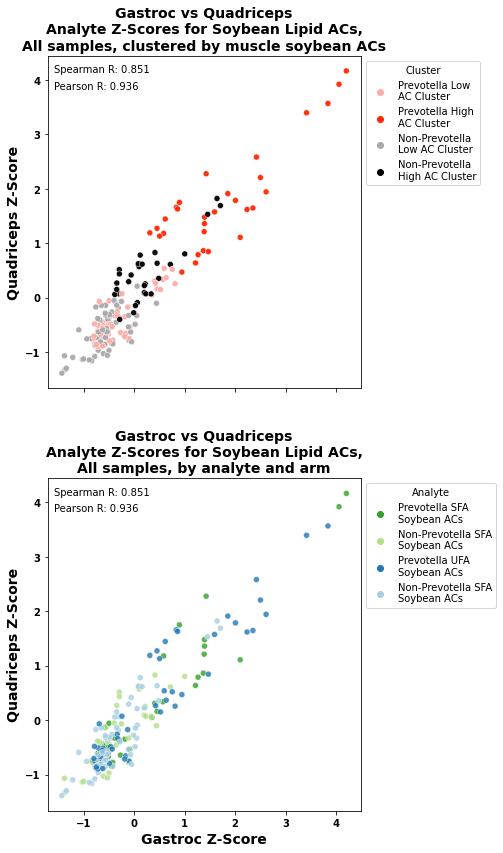

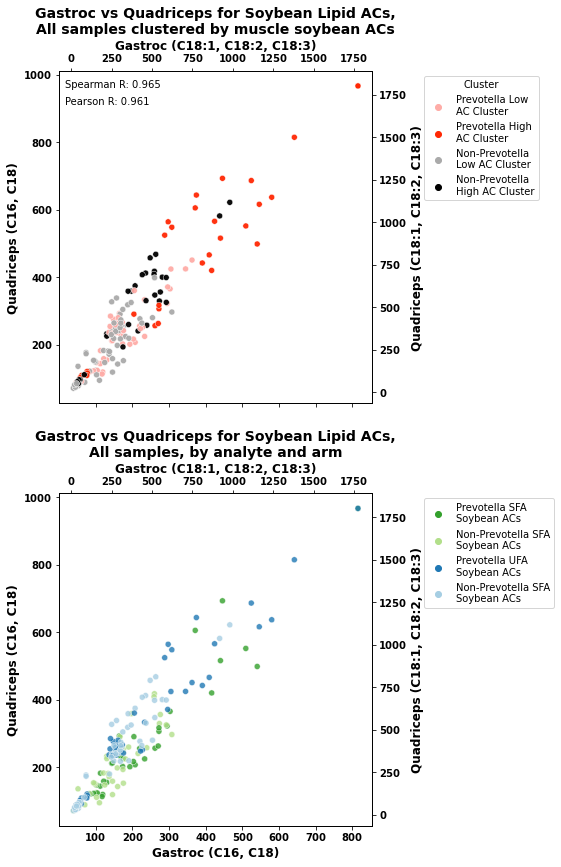

In [11]:
overwrite = True 
tissue_tag = "GQ"
clusters_path = "{0}/cluster/{1}".format(figures_dir,tissue_tag)
if not os.path.exists(clusters_path):
    os.makedirs(clusters_path)

zscore_analyte_2panel_fpath = "{0}/soybean5AC_clusters_analyte_{1}2panel_zscore.png".format(clusters_path,tissue_tag)
if not os.path.exists(zscore_analyte_2panel_fpath) or overwrite: 
    fig = SCC_plot_clusters_analytes(tissue_AC_df,soybean_5ACs,obs_df=soybean5_skmuscle_obs_df,tissue1="Gastroc",
                         tissue2="Quadriceps",title_analytes_label="Soybean Lipid ACs",hue_type="cluster_analyte",
                        axes_analyte_map=analyte_ax_map_5AC,zscore=True,title_clusters_label="muscle soybean ACs")
    plt.savefig(zscore_analyte_2panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")
raw_analyte_2panel_fpath = "{0}/soybean5AC_clusters_analyte_{1}2panel_raw.png".format(clusters_path,tissue_tag)
if not os.path.exists(raw_analyte_2panel_fpath) or overwrite: 
    fig = SCC_plot_clusters_analytes(tissue_AC_df,soybean_5ACs,obs_df=soybean5_skmuscle_obs_df,tissue1="Gastroc",
                         tissue2="Quadriceps",title_analytes_label="Soybean Lipid ACs",hue_type="cluster_analyte",
                        axes_analyte_map=analyte_ax_map_5AC,zscore=False,title_clusters_label="muscle soybean ACs") #no zscore version 
    plt.savefig(raw_analyte_2panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")


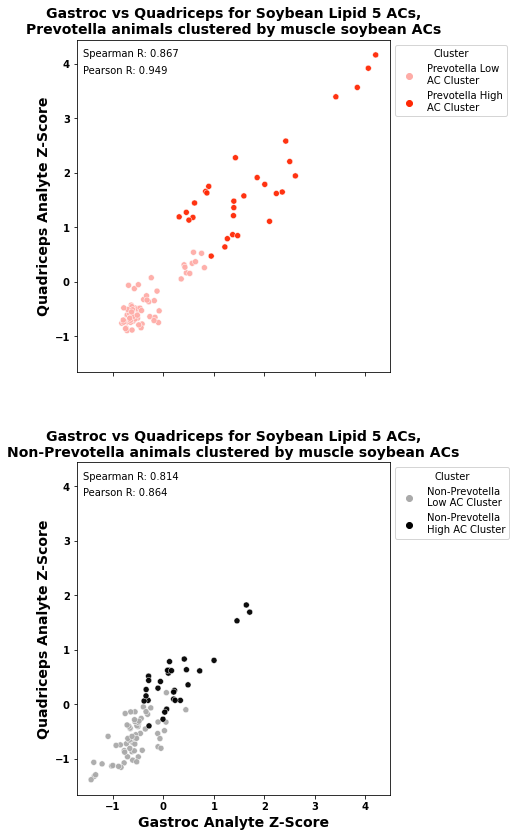

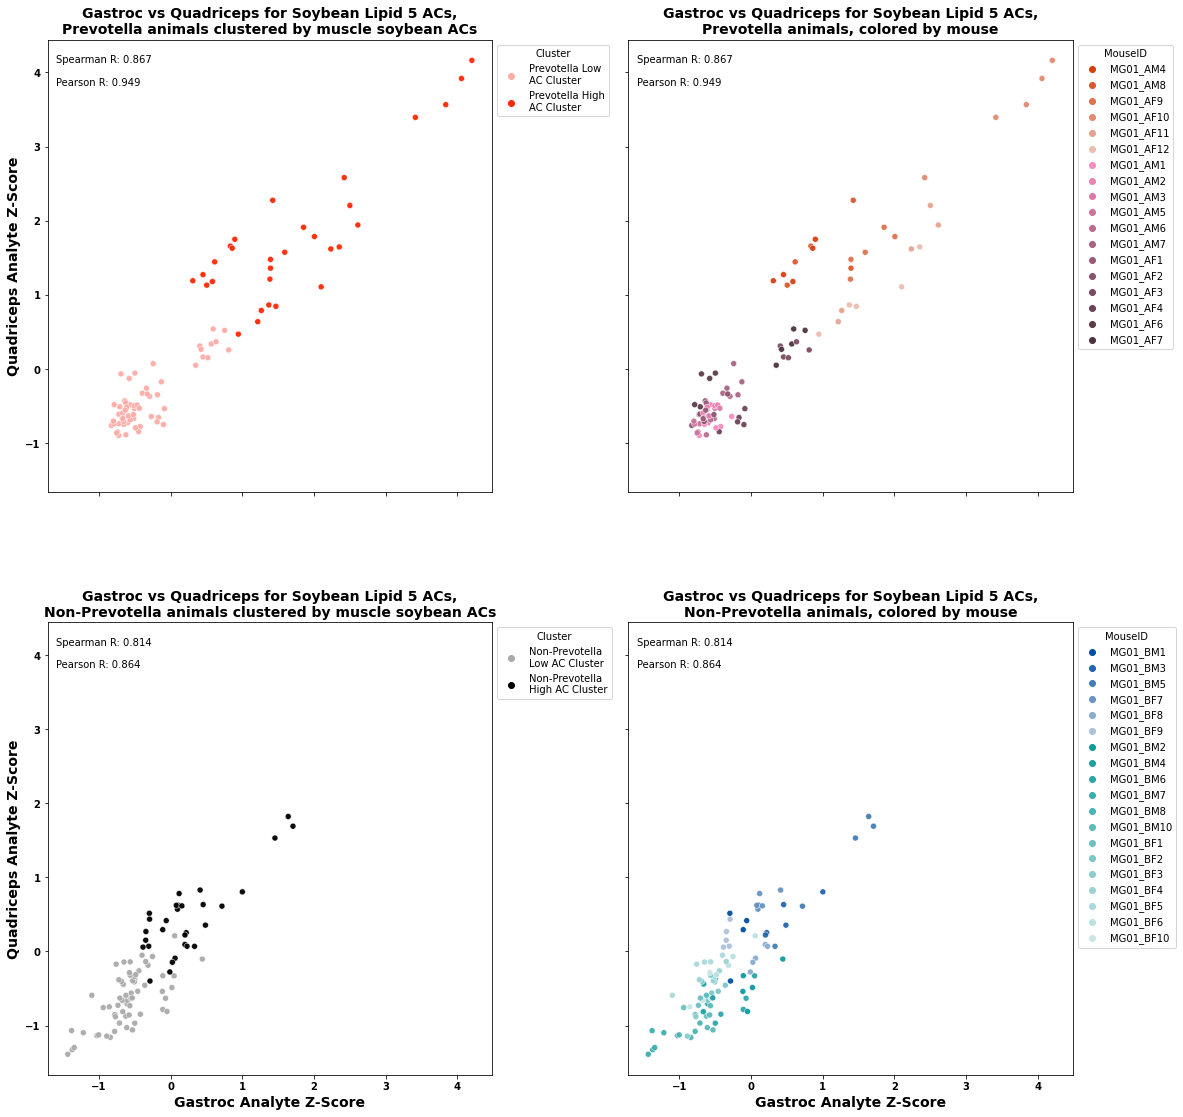

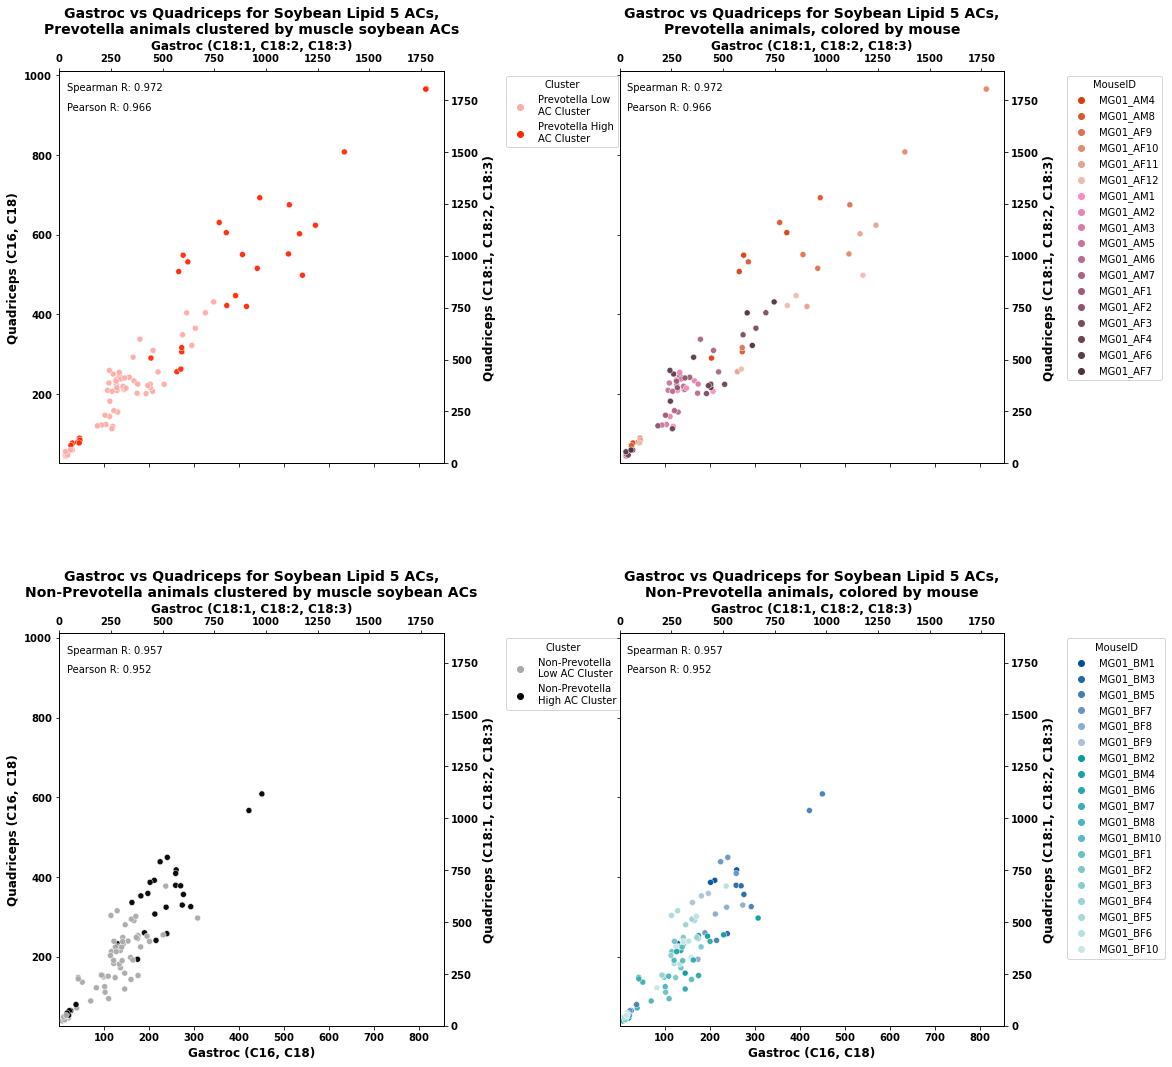

In [12]:
analyte_ax_map = {"C16":0,"C18":0,"C18:1":1,"C18:2":1}
analyte_ax_map_5AC = {"C16":0,"C18":0,"C18:1":1,"C18:2":1,"C18:3":1}
analyte_ax_map_5AC_single_ax = {"C16":0,"C18":0,"C18:1":0,"C18:2":0,"C18:3":0}
#Gastroc Quadriceps plots 
tissue_tag = "GQ"
clusters_path = "{0}/cluster/{1}".format(figures_dir,tissue_tag)
if not os.path.exists(clusters_path):
    os.makedirs(clusters_path)

overwrite = True
if not os.path.exists("{0}/soybean5AC_clusters_2panel.png".format(clusters_path)) or overwrite: 
    fig = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=soybean5_skmuscle_obs_df,tissue1="Gastroc",
                         tissue2="Quadriceps",title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster",
                        axes_analyte_map=analyte_ax_map_5AC,zscore=True,title_clusters_label="muscle soybean ACs")
    plt.savefig("{0}/soybeanAC_clusters_2panel_{1}.png".format(clusters_path,tissue_tag),
                dpi=300,bbox_inches="tight",facecolor="w")

mouseID_4panel_fpath = "{0}/soybean5AC_4panel_mouseID_zscore_{1}.png".format(clusters_path,tissue_tag)    
if not os.path.exists(mouseID_4panel_fpath) or overwrite: 
    fig_mouse = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=soybean5_skmuscle_obs_df,tissue1="Gastroc",
                     tissue2="Quadriceps",title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster_mouse",
                    axes_analyte_map=analyte_ax_map_5AC,zscore=True,title_clusters_label="muscle soybean ACs")
    plt.savefig(mouseID_4panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")

mouseID_4panel_fpath = "{0}/soybean5AC_4panel_mouseID_{1}.png".format(clusters_path,tissue_tag)    
if not os.path.exists(mouseID_4panel_fpath) or overwrite: 
    fig_mouse = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=soybean5_skmuscle_obs_df,tissue1="Gastroc",
                     tissue2="Quadriceps",title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster_mouse",
                    axes_analyte_map=analyte_ax_map_5AC,zscore=False,title_clusters_label="muscle soybean ACs")
    plt.savefig(mouseID_4panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")
    
    

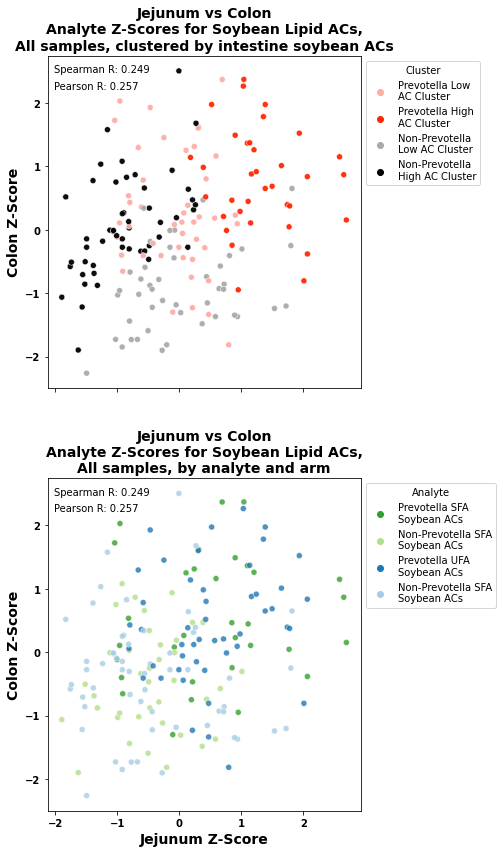

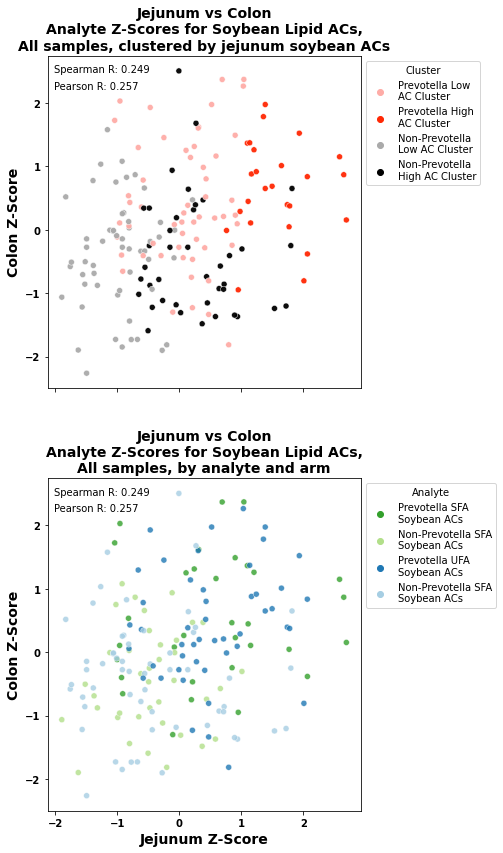

In [13]:
overwrite = True 
tissue_tag = "JC"
clusters_path = "{0}/cluster/{1}".format(figures_dir,tissue_tag)
if not os.path.exists(clusters_path):
    os.makedirs(clusters_path)

tissue1 = "Jejunum"
tissue2 = "Colon"
cluster_obs_df = soybean_intestine_obs_df
analyte_axes_map = analyte_ax_map_5AC 


zscore_analyte_2panel_fpath = "{0}/soybean5AC_clusters_analyte_{1}2panel_zscore.png".format(clusters_path,tissue_tag)
if not os.path.exists(zscore_analyte_2panel_fpath) or overwrite: 
    fig = SCC_plot_clusters_analytes(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
                         tissue2=tissue2,title_analytes_label="Soybean Lipid ACs",hue_type="cluster_analyte",
                        axes_analyte_map=analyte_axes_map,zscore=True,title_clusters_label="intestine soybean ACs")
    plt.savefig(zscore_analyte_2panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")
# raw_analyte_2panel_fpath = "{0}/soybean5AC_clusters_analyte_{1}2panel_raw.png".format(clusters_path,tissue_tag)
# if not os.path.exists(raw_analyte_2panel_fpath) or overwrite: 
#     fig = SCC_plot_clusters_analytes(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
#                          tissue2=tissue2,title_analytes_label="Soybean Lipid ACs",hue_type="cluster_analyte",
#                         axes_analyte_map=analyte_axes_map,zscore=False) #no zscore version 
#     plt.savefig(raw_analyte_2panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")
    
tissue_tag = "JC_jejunumclusters"
clusters_path = "{0}/cluster/{1}".format(figures_dir,tissue_tag)
if not os.path.exists(clusters_path):
    os.makedirs(clusters_path)

tissue1 = "Jejunum"
tissue2 = "Colon"
cluster_obs_df = soybean_jej_obs_df
analyte_axes_map = analyte_ax_map_5AC 


zscore_analyte_2panel_fpath = "{0}/soybean5AC_clusters_analyte_{1}2panel_zscore.png".format(clusters_path,tissue_tag)
if not os.path.exists(zscore_analyte_2panel_fpath) or overwrite: 
    fig = SCC_plot_clusters_analytes(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
                         tissue2=tissue2,title_analytes_label="Soybean Lipid ACs",hue_type="cluster_analyte",
                        axes_analyte_map=analyte_axes_map,zscore=True,title_clusters_label="jejunum soybean ACs")
    plt.savefig(zscore_analyte_2panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")
# raw_analyte_2panel_fpath = "{0}/soybean5AC_clusters_analyte_{1}2panel_raw.png".format(clusters_path,tissue_tag)
# if not os.path.exists(raw_analyte_2panel_fpath) or overwrite: 
#     fig = SCC_plot_clusters_analytes(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
#                          tissue2=tissue2,title_analytes_label="Soybean Lipid ACs",hue_type="cluster_analyte",
#                         axes_analyte_map=analyte_axes_map,zscore=False) #no zscore version 
#     plt.savefig(raw_analyte_2panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")


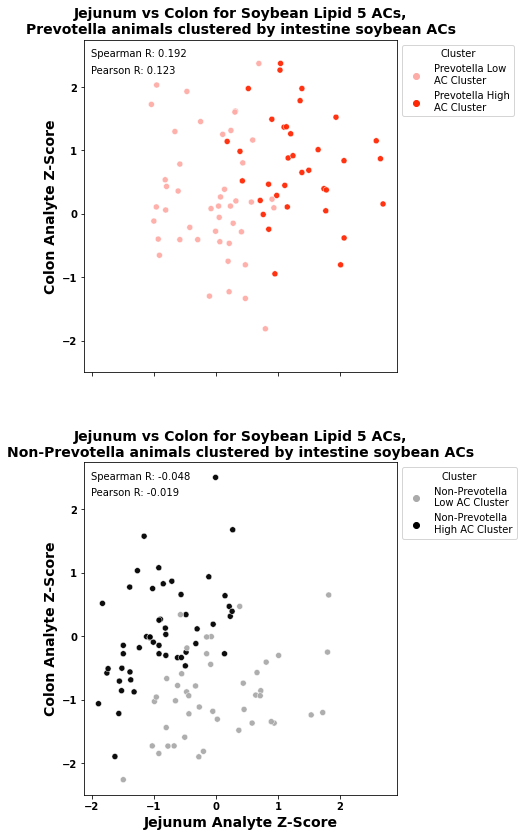

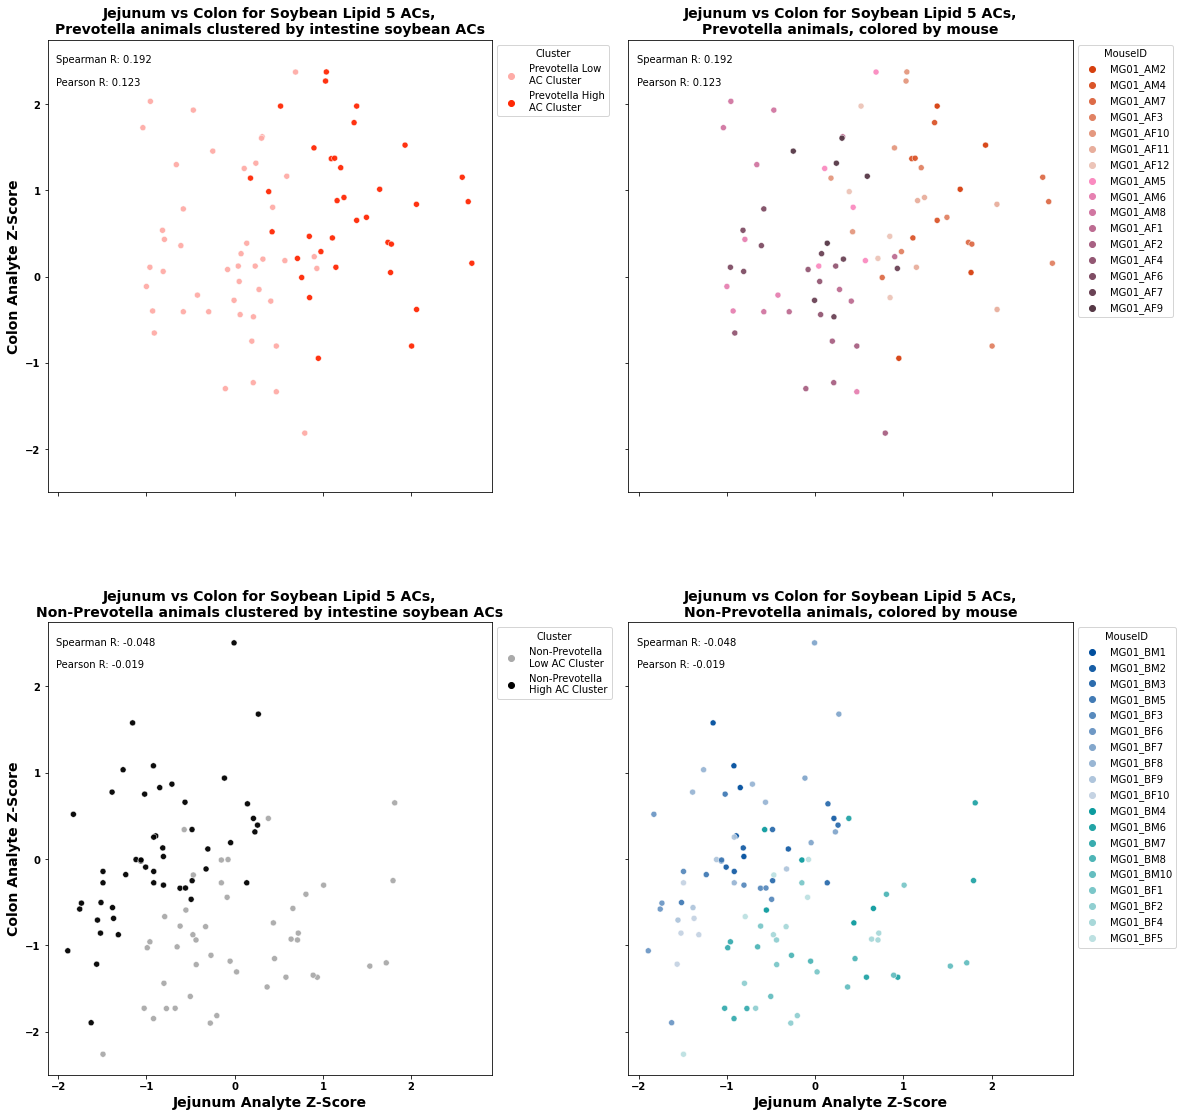

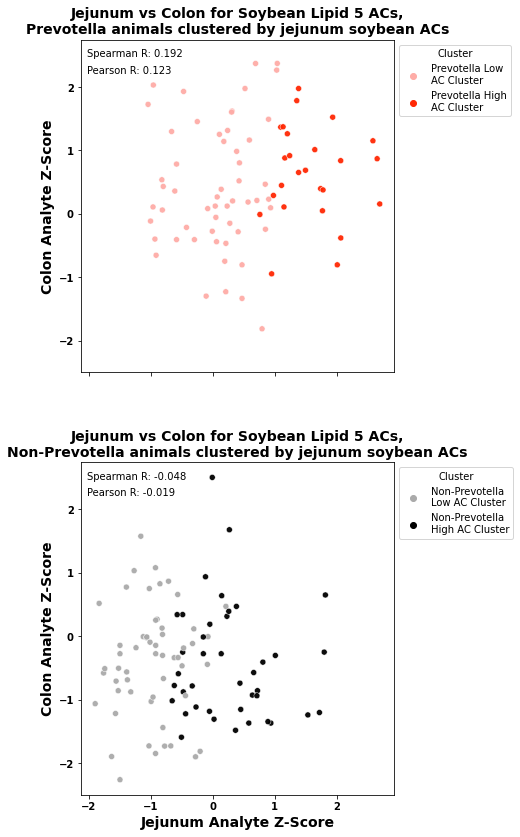

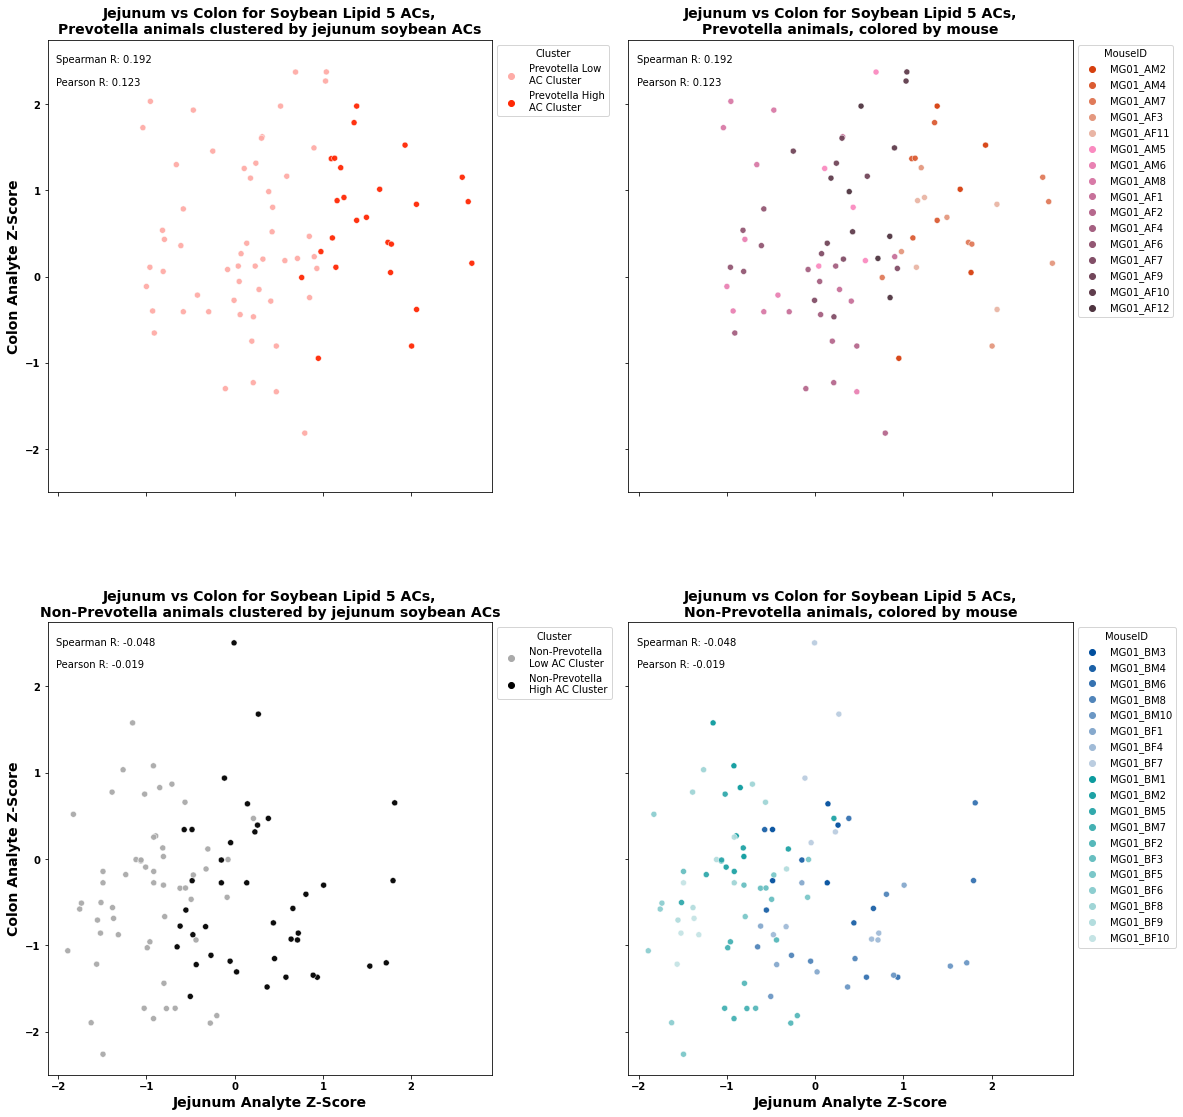

In [14]:
tissue_tag = "JC"
clusters_path = "{0}/cluster/{1}".format(figures_dir,tissue_tag)
if not os.path.exists(clusters_path):
    os.makedirs(clusters_path)

tissue1 = "Jejunum"
tissue2 = "Colon"
cluster_obs_df = soybean_intestine_obs_df
analyte_axes_map = analyte_ax_map_5AC     
    
    
overwrite = True
arm_split_2panel_fpath = "{0}/soybean5AC_clusters_2panel.png".format(clusters_path)
if not os.path.exists(arm_split_2panel_fpath) or overwrite: 
    fig = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
                         tissue2=tissue2,title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster",
                        axes_analyte_map=analyte_axes_map,zscore=True,title_clusters_label="intestine soybean ACs")
    plt.savefig("{0}/soybeanAC_clusters_2panel_{1}.png".format(clusters_path,tissue_tag),
                dpi=300,bbox_inches="tight",facecolor="w")

mouseID_4panel_fpath = "{0}/soybean5AC_4panel_mouseID_zscore_{1}.png".format(clusters_path,tissue_tag)    
if not os.path.exists(mouseID_4panel_fpath) or overwrite: 
    fig_mouse = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
                     tissue2=tissue2,title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster_mouse",
                    axes_analyte_map=analyte_axes_map,zscore=True,title_clusters_label="intestine soybean ACs")
    plt.savefig(mouseID_4panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")
    
#
tissue_tag = "JC_jejunumclusters"
clusters_path = "{0}/cluster/{1}".format(figures_dir,tissue_tag)
if not os.path.exists(clusters_path):
    os.makedirs(clusters_path)

tissue1 = "Jejunum"
tissue2 = "Colon"
cluster_obs_df = soybean_jej_obs_df
analyte_axes_map = analyte_ax_map_5AC     
    
    
overwrite = True
arm_split_2panel_fpath = "{0}/soybean5AC_clusters_2panel.png".format(clusters_path)
if not os.path.exists(arm_split_2panel_fpath) or overwrite: 
    fig = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
                         tissue2=tissue2,title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster",
                        axes_analyte_map=analyte_axes_map,zscore=True,title_clusters_label="jejunum soybean ACs")
    plt.savefig("{0}/soybeanAC_clusters_2panel_{1}.png".format(clusters_path,tissue_tag),
                dpi=300,bbox_inches="tight",facecolor="w")

mouseID_4panel_fpath = "{0}/soybean5AC_4panel_mouseID_zscore_{1}.png".format(clusters_path,tissue_tag)    
if not os.path.exists(mouseID_4panel_fpath) or overwrite: 
    fig_mouse = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
                     tissue2=tissue2,title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster_mouse",
                    axes_analyte_map=analyte_axes_map,zscore=True,title_clusters_label="jejunum soybean ACs")
    plt.savefig(mouseID_4panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")

# mouseID_4panel_fpath = "{0}/soybean5AC_4panel_mouseID_{1}.png".format(clusters_path,tissue_tag)    
# if not os.path.exists(mouseID_4panel_fpath) or overwrite: 
#     fig_mouse = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=soybean5_skmuscle_obs_df,tissue1="Gastroc",
#                      tissue2="Quadriceps",title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster_mouse",
#                     axes_analyte_map=analyte_ax_map_5AC,zscore=False)
#     plt.savefig(mouseID_4panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")

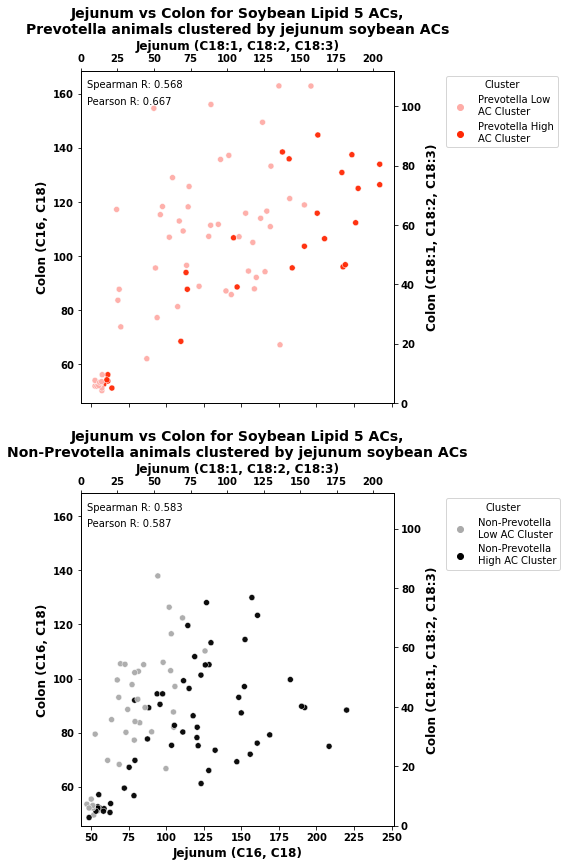

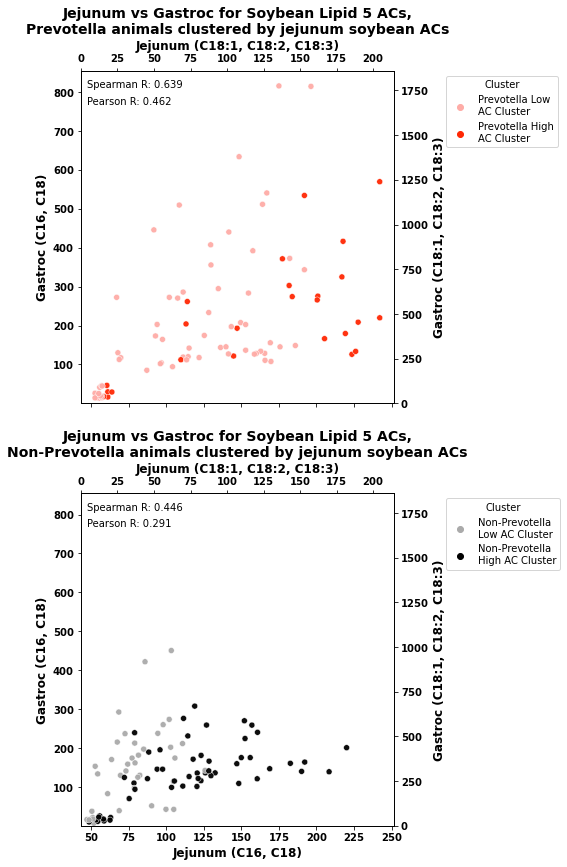

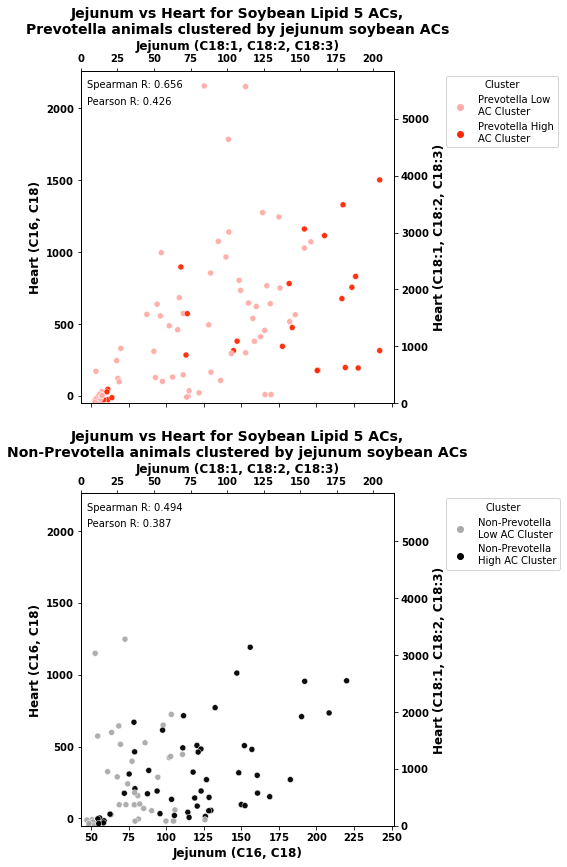

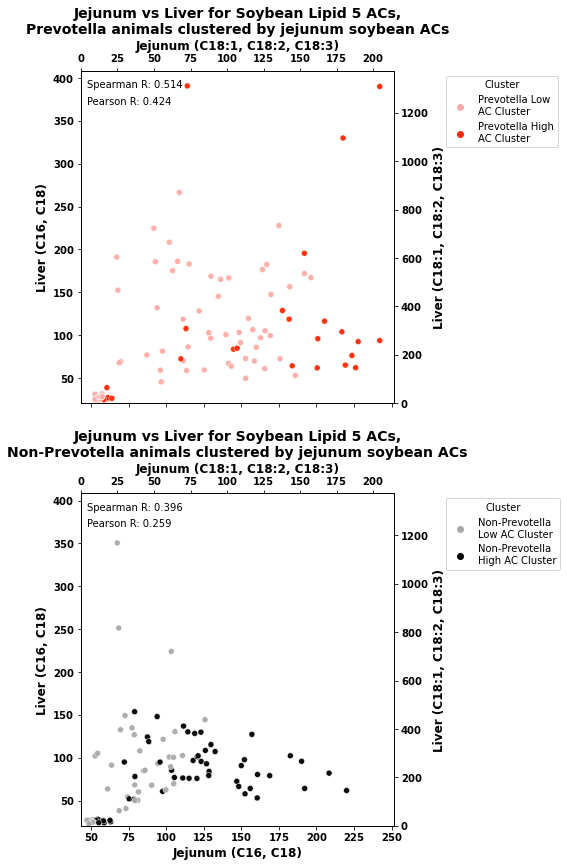

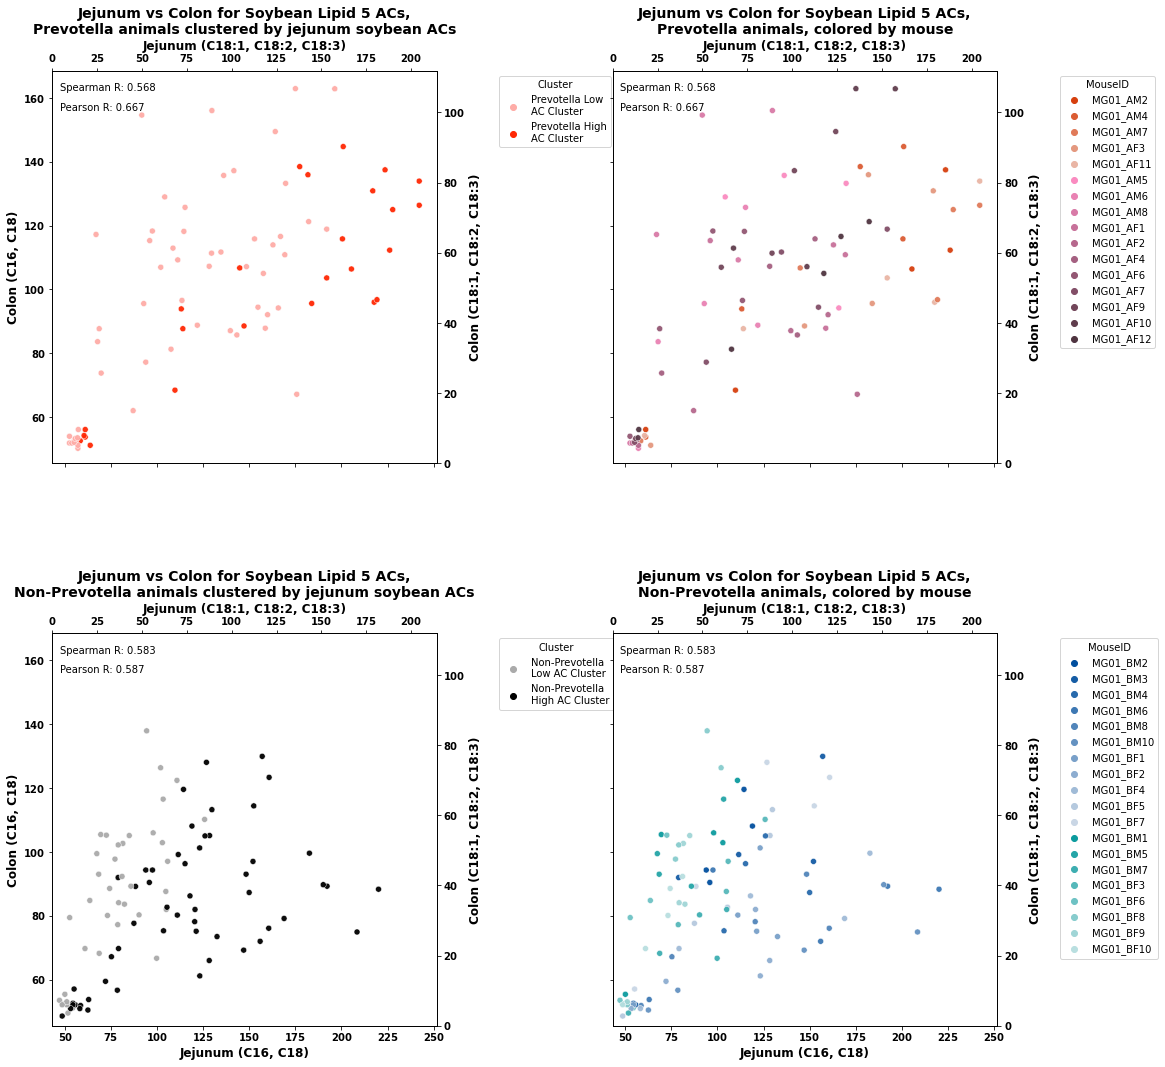

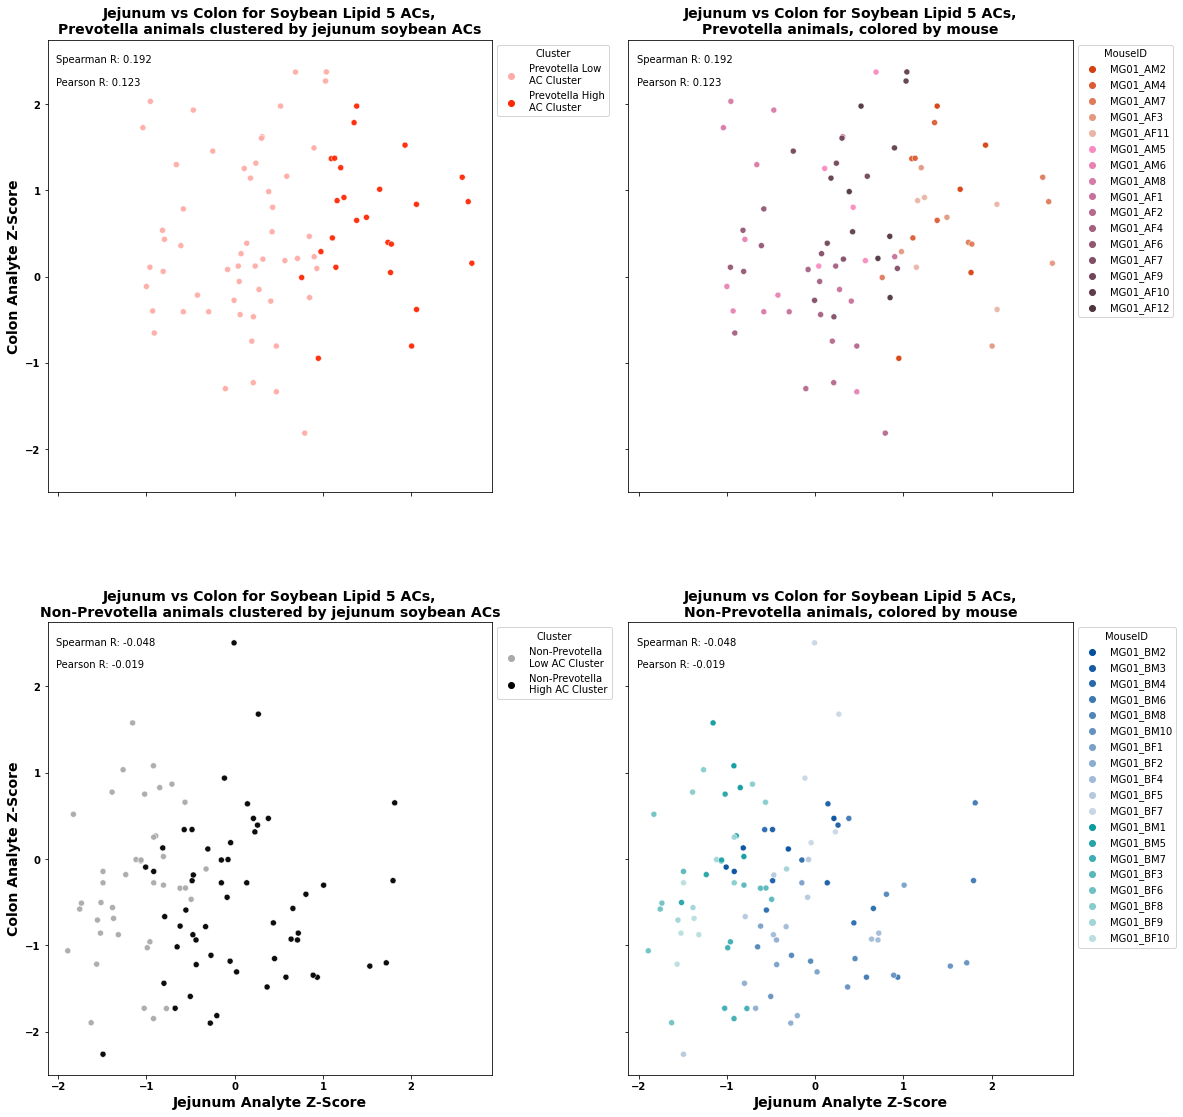

In [15]:
tissue_tag = "JejunumCluster"
clusters_path = "{0}/cluster/{1}".format(figures_dir,tissue_tag)
if not os.path.exists(clusters_path):
    os.makedirs(clusters_path)

tissue1 = "Jejunum"
tissue2 = "Colon"
cluster_obs_df = soybean4_jej_obs_df
analyte_axes_map = analyte_ax_map_5AC     
overwrite=True

for tissue2 in ["Colon","Gastroc","Heart","Liver"]:
    arm_split_2panel_fpath = "{0}/soybean5AC_clusters_2panel_{1}{2}.png".format(clusters_path,tissue1[0],tissue2[0])
    if not os.path.exists(arm_split_2panel_fpath) or overwrite: 
        fig = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
                             tissue2=tissue2,title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster",
                            axes_analyte_map=analyte_axes_map,zscore=False,title_clusters_label="jejunum soybean ACs")
        plt.savefig(arm_split_2panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")

tissue2 = "Colon"        
mouseID_4panel_fpath = "{0}/soybean5AC_4panel_mouseID_raw_{1}{2}.png".format(clusters_path,tissue1[0],tissue2[0])    
if not os.path.exists(mouseID_4panel_fpath) or overwrite: 
    fig_mouse = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
                     tissue2=tissue2,title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster_mouse",
                    axes_analyte_map=analyte_axes_map,zscore=False,title_clusters_label="jejunum soybean ACs")
    plt.savefig(mouseID_4panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")
mouseID_4panel_fpath = "{0}/soybean5AC_4panel_mouseID_zscore_{1}{2}.png".format(clusters_path,tissue1[0],tissue2[0])    
if not os.path.exists(mouseID_4panel_fpath) or overwrite: 
    fig_mouse = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
                     tissue2=tissue2,title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster_mouse",
                    axes_analyte_map=analyte_axes_map,zscore=True,title_clusters_label="jejunum soybean ACs")
    plt.savefig(mouseID_4panel_fpath,dpi=300,bbox_inches="tight",facecolor="w")

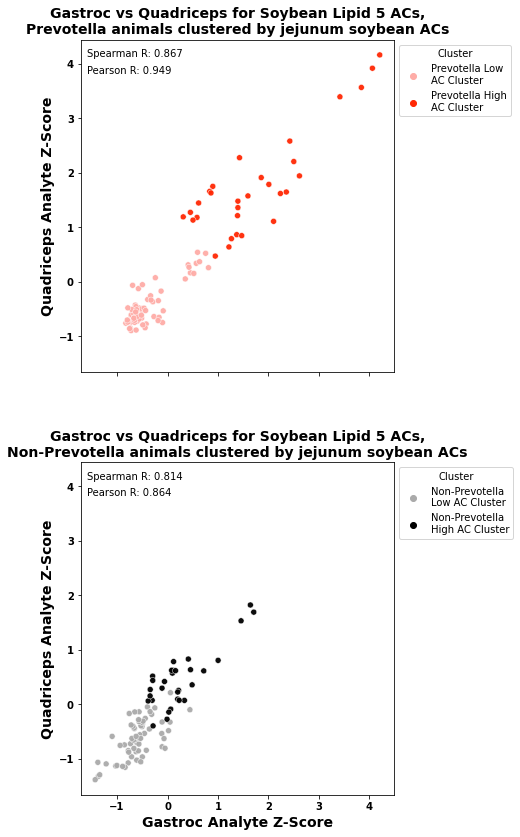

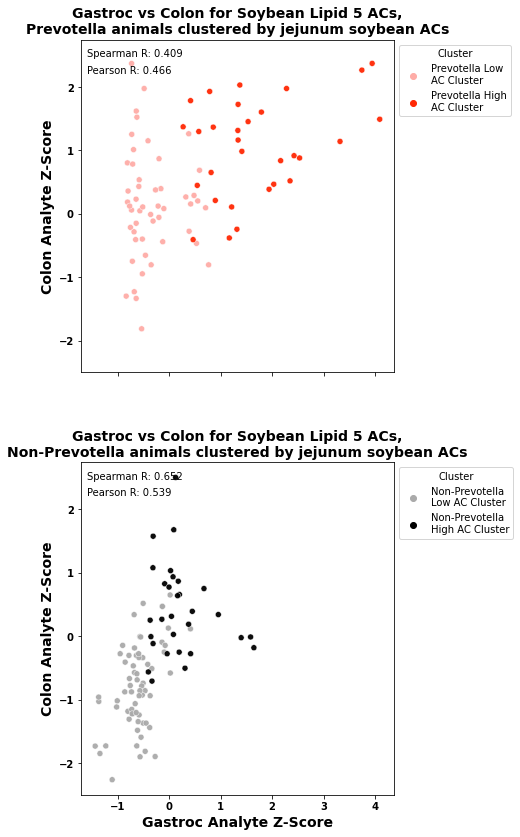

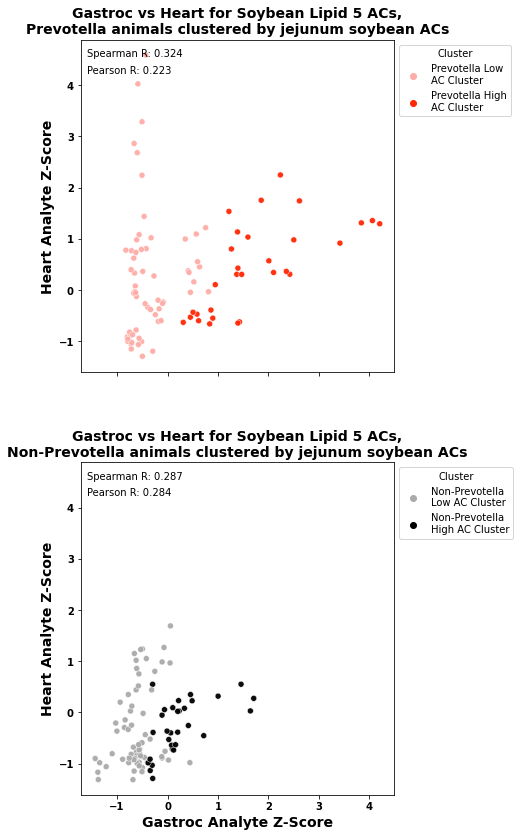

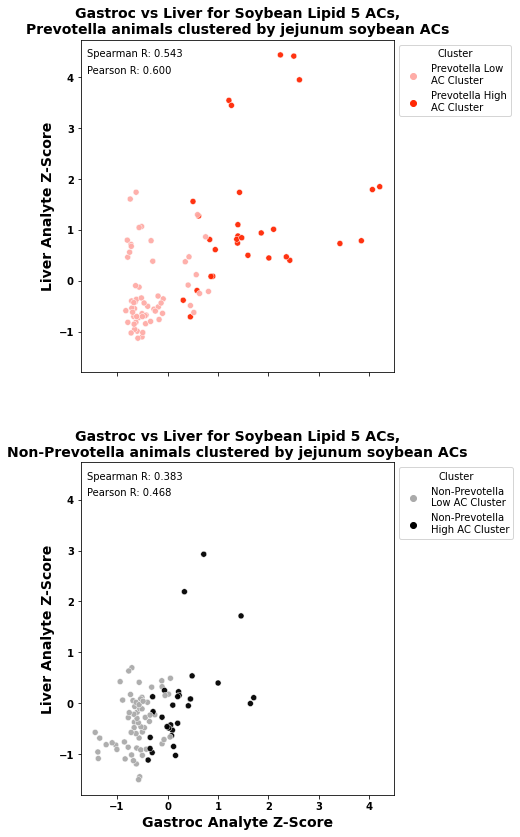

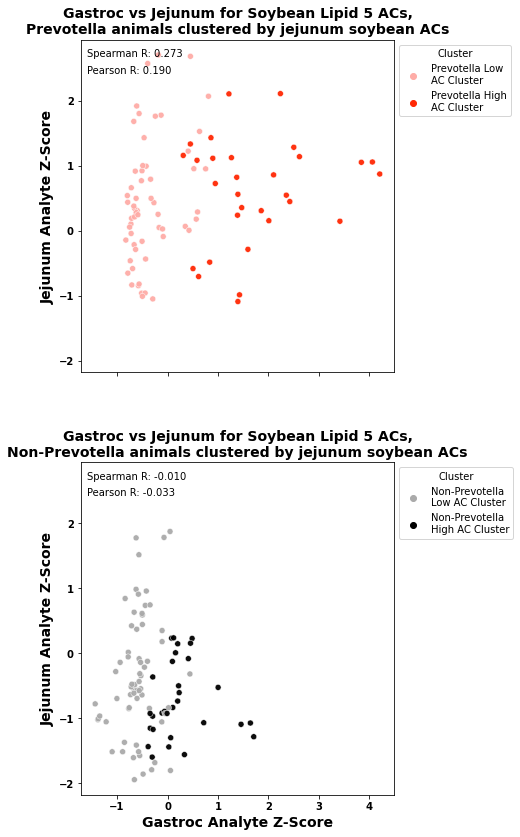

In [16]:
tissue_tag = "GastrocCluster"
clusters_path = "{0}/cluster/{1}".format(figures_dir,tissue_tag)
if not os.path.exists(clusters_path):
    os.makedirs(clusters_path)

tissue1 = "Gastroc"
cluster_obs_df = soybean5_skmuscle_obs_df
analyte_axes_map = analyte_ax_map_5AC     
overwrite=True

for tissue2 in ["Quadriceps","Colon","Heart","Liver","Jejunum"]:
    arm_split_2panel_fpath = "{0}/soybean5AC_clusters_2panel_{1}{2}.png".format(clusters_path,tissue1[0],tissue2[0])
    if not os.path.exists(arm_split_2panel_fpath) or overwrite: 
        fig = SCC_plot_arms_clusters(tissue_AC_df,soybean_5ACs,obs_df=cluster_obs_df,tissue1=tissue1,
                             tissue2=tissue2,title_analytes_label="Soybean Lipid 5 ACs",hue_type="cluster",
                            axes_analyte_map=analyte_axes_map,zscore=True,title_clusters_label="jejunum soybean ACs")
        plt.savefig("{0}/soybeanAC_clusters_2panel_{1}.png".format(clusters_path,tissue_tag),
                    dpi=300,bbox_inches="tight",facecolor="w")

In [234]:
import nbimporter
import MS_analyte_bar as analyte_bar
import matplotlib.patches as mpatches
from importlib import reload

reload(analyte_bar)

#Ketone and glycerol single analyte 
kg_path = "{0}/20220714_plasma_KETGLYC.csv".format(csv_dir)
kg_df = pd.read_csv(kg_path,header=0)
kg_df.rename(columns={"KET":"Ketones"},inplace=True)

#NEFA data 
NEFA_path = "{0}/20220608_Lee-Chang_plasma_NEFA.csv".format(csv_dir)
NEFA_df = pd.read_csv(NEFA_path,header=0)
NEFA_df.rename(columns={"NEFA":"Non-Esterified Fatty Acids"},inplace=True)

BW_rel23_path = "{0}/BW_rel23_long.csv".format(csv_dir)
BW_rel18_path = "{0}/BW_rel18_long.csv".format(csv_dir)
BW_rel23_df = pd.read_csv(BW_rel23_path,header=0)
BW_rel23_df.loc[:,"Weight"] = BW_rel23_df.loc[:,"Weight"]*100
BW_rel23_sac_weight = BW_rel23_df.loc[BW_rel23_df["Day"]==52]
display(BW_rel23_sac_weight)

soybean5_skmuscle_obs_df = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_5ACs,tissues=["Gastroc","Quadriceps"])
soybean5_skmuscle_unstaggered_obs = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_5ACs,
                                                      tissues=["Gastroc","Quadriceps"],offset=False)
soybean5_heart_unstaggered_obs = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_5ACs,
                                                      tissues=["Heart"],offset=False)
soybean5_jej_unstaggered_obs = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_5ACs,tissues=["Jejunum"],offset=False)
soybean5_intestines_unstaggered_obs = kmeans_cluster_ms(tissue_AC_df,analytes=soybean_5ACs,
                                                        tissues=["Jejunum","Colon"],offset=False)

HWDC_arm_cluster_palette={"A_0":"#FEACA7","A_1":"#FF2804","B_0":"#AAAAAA","B_1":"#000000"}
tissue_tag = "GQ"
clusters_path = "{0}/cluster/{1}/cluster_bar".format(figures_dir,tissue_tag)
if not os.path.exists(clusters_path):
    os.makedirs(clusters_path)


def arm_cluster_analyte_bar(data_df,cluster_obs_df,analyte,tissue,sampleID_col="Mouse_ID",
                            palette=HWDC_arm_cluster_palette, units="µM",cluster_legend_label="Soybean ACs",
                           fig_fmt="pdf",figpath_cluster_tag=""):
    
    if len(cluster_obs_df) < len(data_df): #Mismatch length handling for missing data 
        data_df = data_df.loc[data_df[sampleID_col].isin(obs_df.index)]
        
    if "Tissue" in data_df.columns:
        data_df = data_df.loc[data_df["Tissue"]==tissue]
    
    #Adding in Arm/Cluster Data to data_df 
    data_df = data_df.set_index(sampleID_col)
    data_df.loc[:,"Arm"] = cluster_obs_df["Arm"]
    data_df.loc[:,"Cluster"] = cluster_obs_df["Cluster"].astype(int)
    data_df.loc[:,"Arm_Cluster"] = data_df["Arm"] + "_" + data_df["Cluster"].astype(str)
    data_df.reset_index(inplace=True)
    
    data_A, data_B = data_df[data_df["Arm"]=="A"], data_df[data_df["Arm"]=="B"]
    #Fig, ax
    fig,ax = plt.subplots(1,1,figsize=(3,6))
    #Barplot + swarmplot overlay 
    sns.barplot(data=data_df,x="Arm_Cluster",y=analyte,ax=ax,zorder=0,palette=palette.values(),
                            capsize=0.1,errwidth=1,alpha=0.7,order=palette.keys())
    sns.swarmplot(data=data_df,x="Arm_Cluster",y=analyte, ax=ax, zorder=1,palette=palette.values(),
                  dodge=True,order=palette.keys())
    #Change error bar colors to match bars 
    lines_per_err = 3
    for i, line in enumerate(ax.get_lines()):
        newcolor = list(HWDC_cluster_palette.values())[i//lines_per_err]
        line.set_color(newcolor)

    #Significance bracket plotting
    ymin, ymax = ax.get_ylim()
    y1, y2 = ymax - (ymax-ymin)*0.01, ymax
    #Arm A Bars Significance Bracket
    stat,pval,sigstr = analyte_bar.single_analyte_stats(data_A,analyte_col=analyte,tissue=tissue,
                                                        sampleID_col=sampleID_col,split="cluster")
    analyte_bar.significance_bracket(ax,pval,sigstr,sigstr_fmt="std",x1=0,x2=1,y1=y1,y2=y2)
    #Arm B Bars Significance Bracket 
    stat,pval,sigstr = analyte_bar.single_analyte_stats(data_B,analyte_col=analyte,tissue=tissue,
                                                        sampleID_col=sampleID_col,split="cluster")
    analyte_bar.significance_bracket(ax,pval,sigstr,sigstr_fmt="std",x1=2,x2=3,y1=y1,y2=y2)

    ax.set_xlabel("Analyte KMeans Cluster".format(cluster_legend_label))
    ax.set_ylabel("{0} ({1})".format(analyte,units))
    ax.set_xticklabels(ax.get_xticklabels(),size=0)

    #Bolding of fonts 
    labels =  ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontweight('bold') for label in labels]
    ax.set_xlabel(ax.get_xlabel(),fontweight="bold",fontsize=14)
    ax.set_ylabel(ax.get_ylabel(),fontweight="bold",fontsize=14)

    #Custom legend entries 
    A0_patch = mpatches.Patch(color="#FEACA7", label='(+) $\it{Prevotella}$ Low\n'+'{0}'.format(cluster_legend_label))
    A1_patch = mpatches.Patch(color="#FF2804", label='(+) $\it{Prevotella}$ High\n'+'{0}'.format(cluster_legend_label))
    B0_patch = mpatches.Patch(color="#AAAAAA", label='(—) $\it{Prevotella}$ Low\n'+'{0}'.format(cluster_legend_label))
    B1_patch = mpatches.Patch(color="#000000", label='(—) $\it{Prevotella}$ High\n'+'{0}'.format(cluster_legend_label))
    ax.legend(handles=[A0_patch,A1_patch,B0_patch,B1_patch])
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
    fig_path = "{0}/{1}_{2}_{3}.{4}".format(clusters_bar_path,tissue,analyte,figpath_cluster_tag,fig_fmt)
    plt.savefig(fig_path,dpi=300,bbox_inches="tight",facecolor="w",format=fig_fmt)




,MouseID,Isolator,Sex,Cage,Day,Weight
54,MG01_AM1,A,M,1,52,144.5783
55,MG01_AM2,A,M,1,52,130.2353
56,MG01_AM3,A,M,1,52,137.3810
57,MG01_AM4,A,M,1,52,138.2609
58,MG01_AM5,A,M,2,52,125.5696
59,MG01_AM6,A,M,2,52,147.6923
60,MG01_AM7,A,M,2,52,167.6389
61,MG01_AM8,A,M,2,52,157.2152
62,MG01_AF1,A,F,1,52,119.8837
63,MG01_AF2,A,F,1,52,155.5263


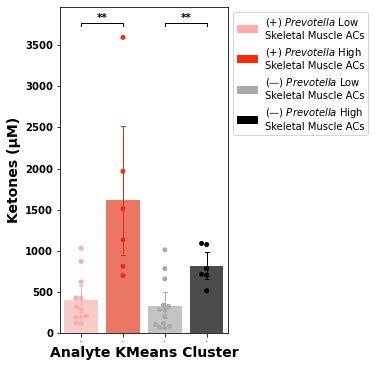

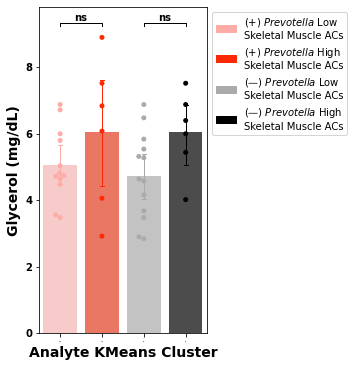

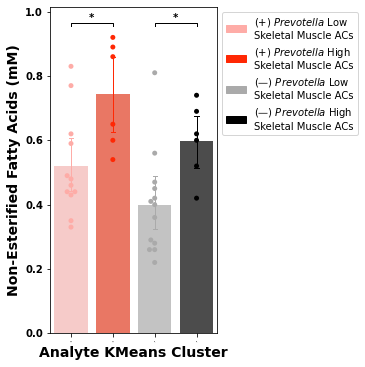

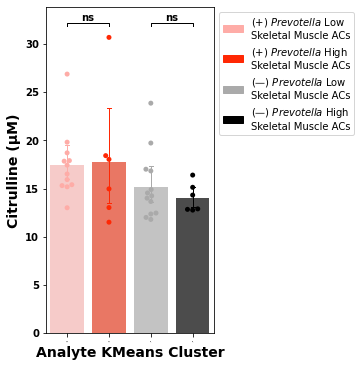

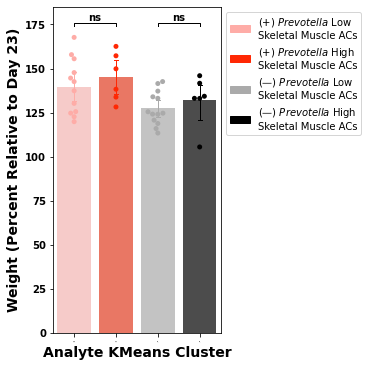

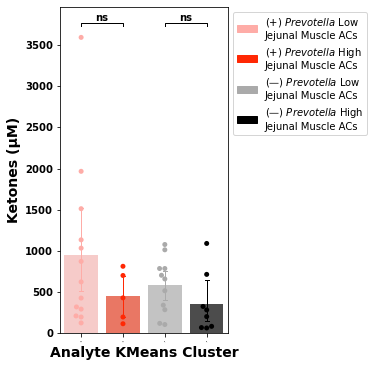

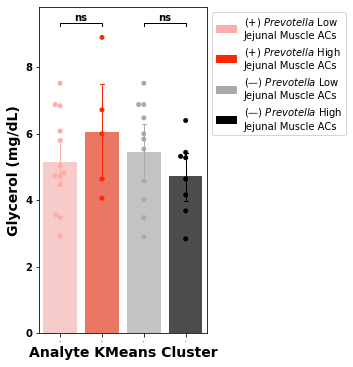

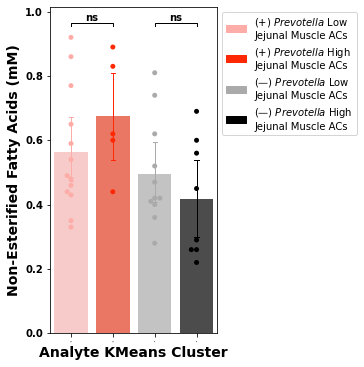

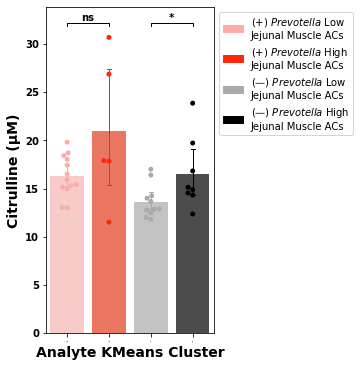

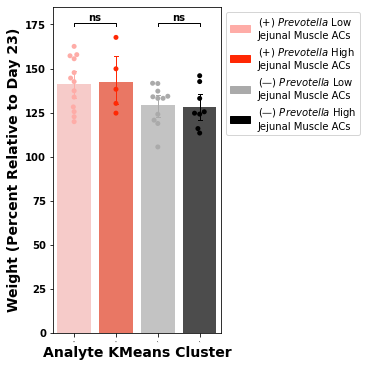

In [236]:
tissue_tag = "GQ"
clusters_bar_path = "figures/cluster_bar/{0}".format(tissue_tag)
if not os.path.exists(clusters_bar_path):
    os.makedirs(clusters_bar_path)    
    
    
obs_df = soybean5_skmuscle_unstaggered_obs
# obs_df = soybean5_heart_unstaggered_obs
cluster_legend_label = "Skeletal Muscle ACs"
figpath_cluster_tag="skm_soyACs"

analyte = "Ketones"
units = "µM"    
arm_cluster_analyte_bar(kg_df,obs_df,analyte,tissue="plasma",sampleID_col="Mouse_ID",
                        palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
                       figpath_cluster_tag=figpath_cluster_tag)

analyte = "Glycerol"
units = "mg/dL"    
arm_cluster_analyte_bar(kg_df,obs_df,analyte,tissue="plasma",sampleID_col="Mouse_ID",
                        palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
                       figpath_cluster_tag=figpath_cluster_tag)

analyte = "Non-Esterified Fatty Acids"
units = "mM"
arm_cluster_analyte_bar(NEFA_df,obs_df,analyte,tissue="Plasma",sampleID_col="Mouse_ID",
                        palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
                       figpath_cluster_tag=figpath_cluster_tag)

analyte = "Citrulline"
units = "µM"    
arm_cluster_analyte_bar(tissue_amine_df,obs_df,analyte,tissue="Jejunum",sampleID_col="SampleID",
                        palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
                       figpath_cluster_tag=figpath_cluster_tag)

analyte = "Weight"
units = "Percent Relative to Day 23"
arm_cluster_analyte_bar(BW_rel23_sac_weight,obs_df,analyte,tissue="",sampleID_col="MouseID",
                        palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
                       figpath_cluster_tag=figpath_cluster_tag)


tissue_tag = "Jejunum"
clusters_bar_path = "figures/cluster_bar/{0}".format(tissue_tag)
if not os.path.exists(clusters_bar_path):
    os.makedirs(clusters_bar_path)    
    
    
obs_df = soybean5_jej_unstaggered_obs

cluster_legend_label = "Jejunal Muscle ACs"
figpath_cluster_tag="jej_soyACs"

analyte = "Ketones"
units = "µM"    
arm_cluster_analyte_bar(kg_df,obs_df,analyte,tissue="plasma",sampleID_col="Mouse_ID",
                        palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
                       figpath_cluster_tag=figpath_cluster_tag)

analyte = "Glycerol"
units = "mg/dL"    
arm_cluster_analyte_bar(kg_df,obs_df,analyte,tissue="plasma",sampleID_col="Mouse_ID",
                        palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
                       figpath_cluster_tag=figpath_cluster_tag)

analyte = "Non-Esterified Fatty Acids"
units = "mM"
arm_cluster_analyte_bar(NEFA_df,obs_df,analyte,tissue="Plasma",sampleID_col="Mouse_ID",
                        palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
                       figpath_cluster_tag=figpath_cluster_tag)

analyte = "Citrulline"
units = "µM"    
arm_cluster_analyte_bar(tissue_amine_df,obs_df,analyte,tissue="Jejunum",sampleID_col="SampleID",
                        palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
                       figpath_cluster_tag=figpath_cluster_tag)

analyte = "Weight"
units = "Percent Relative to Day 23"
arm_cluster_analyte_bar(BW_rel23_sac_weight,obs_df,analyte,tissue="",sampleID_col="MouseID",
                        palette=HWDC_arm_cluster_palette,units=units,cluster_legend_label=cluster_legend_label,
                       figpath_cluster_tag=figpath_cluster_tag)